# Training Deep CNNs

# **Data Augmentation (Simple Explanation)**

Data augmentation is a way to **artificially increase the size of your dataset** by transforming your images. This helps the model **learn better** and **avoid overfitting**.

Think of it as teaching the model:

*"The same object can appear in different ways – flipped, cropped, or with different colors."*

# 1) Why use data augmentation?

Data augmentation synthetically increases the effective size and diversity of a dataset by applying label-preserving transformations. It reduces overfitting, helps models learn invariances (e.g., to viewpoint, lighting, background), and can change which layers/features in a network get affected during training (e.g., MixUp/CutMix — which combine images — have different representational effects than single-image transforms). Augmentations are widely used in vision, audio, and language research as a core regularization method. 

---

# 2) Taxonomy & intuition

- **Geometric / spatial transforms:** flips, rotations, translations, crops, scaling. They teach invariance to viewpoint/position.
- **Photometric / color-space transforms:** brightness, contrast, saturation, hue jitter, solarize. They teach invariance to illumination/colour shifts.
- **Occlusion / erasing:** cutout, random erasing — teach robustness when parts of object are missing.
- **Mixing-based augmentations:** MixUp and CutMix combine **two** images (and interpolate labels) to create new examples; these often have stronger regularizing effects and change deeper-layer representations more than single-image augmentations.
  
---

# **Types of Data Augmentation (Detailed but Simple)**

Data augmentation transforms your images in different ways to help your model **learn better** and **generalize well**. There are several common types:

---

## **1) Flips**

- **What it does:** Flips the image horizontally or vertically.
- **Example:** A cat facing left → flipped → cat facing right.
- **Why it helps:** Many objects look the same even if they are flipped. It teaches the model **orientation invariance** (the object is the same even if mirrored).
- **Use carefully:** For some tasks, like reading digits or text, flipping can **confuse the model**.

## **2) Random Crop / Resized Crop**

- **What it does:** Cuts a random part of the image and resizes it to the original size.
- **Example:** Zooming in on a part of a dog instead of seeing the whole dog.
- **Why it helps:** Makes the model learn from **partial objects** and become **robust to object position and scale**.
- Often used with a small **padding** to slightly shift images.

## **3) Color Jitter**

- **What it does:** Randomly changes brightness, contrast, saturation, or hue.
- **Example:** A red car may appear slightly darker, brighter, or a bit orange.
- **Why it helps:** Makes the model **robust to lighting and color variations**.
- Usually applied with moderate values to **not change the meaning** of the image.

## **4) Random Erasing / Cutout**

- **What it does:** Randomly hides a part of the image by filling it with black or noise.
- **Example:** Covering the tail of a dog in the image.
- **Why it helps:** The model learns to **focus on multiple parts** of the object, not just one distinctive feature.
- Good for **occlusion robustness**, e.g., in real-world images where parts of objects are hidden.

## **5) MixUp**

- **What it does:** Combines two images and their labels.
- **Example:** Mix 70% cat + 30% dog → new image, label = 70% cat + 30% dog.
- **Why it helps:**
    - Smoothens decision boundaries between classes
    - Reduces overfitting and memorization
    - Makes the model handle ambiguous images better
- Works best with a **soft-label-aware loss** (like weighted cross-entropy).

## **6) CutMix**

- **What it does:** Cuts a patch from one image and places it on another.
- **Example:** Replace a square area of a cat image with a square from a dog image.
- **Why it helps:**
    - Preserves parts of the original image, unlike MixUp
    - Helps the model **focus on multiple regions** and learn better
    - Label is weighted according to the area replaced
- Very effective for vision tasks where local features matter.

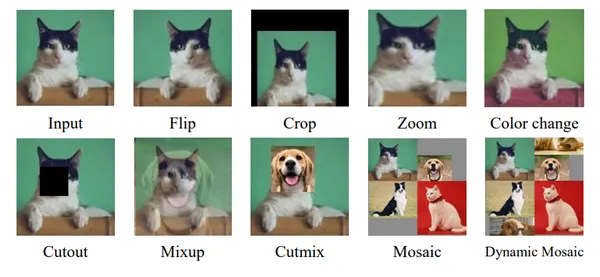

# **Summary**

- **Flips, crop, and color jitter:** teach basic invariances (orientation, position, color).
- **Random erasing / cutout:** teaches robustness to missing parts.
- **MixUp / CutMix:** combine images and labels for **strong regularization**, smoother decision boundaries, and better generalization.

---

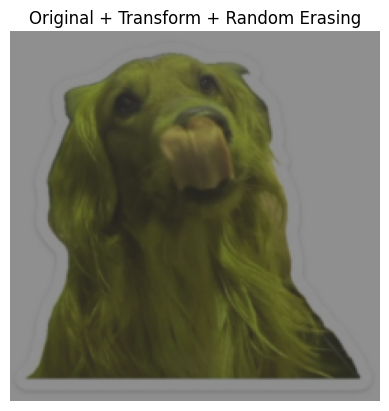

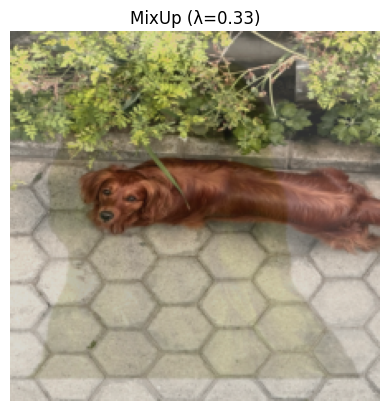

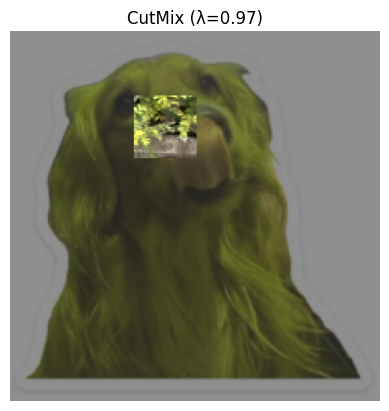

In [4]:
import torch
import random
import math
from PIL import Image
from torchvision import transforms
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt

# ---------------------------
# 1) Load image from your laptop
# ---------------------------
image_path1 = "Corazon.jpeg"  # replace with your image path
image_path2 = "Corazon2.jpeg"  # another image for MixUp / CutMix

img1 = Image.open(image_path1).convert("RGB")
img2 = Image.open(image_path2).convert("RGB")

# ---------------------------
# 2) Apply standard transforms (flip, crop, color jitter, random erasing)
# ---------------------------
transform_list = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor()
])

x1 = transform_list(img1)
x2 = transform_list(img2)

# Apply Random Erasing manually (fill a random rectangle with 0)
if random.random() < 0.25:
    c, h, w = x1.size()
    erase_area = random.uniform(0.02, 0.25) * h * w
    erase_ratio = random.uniform(0.3, 3.3)
    erase_h = int(math.sqrt(erase_area * erase_ratio))
    erase_w = int(math.sqrt(erase_area / erase_ratio))
    x_start = random.randint(0, max(h - erase_h, 0))
    y_start = random.randint(0, max(w - erase_w, 0))
    x1[:, x_start:x_start+erase_h, y_start:y_start+erase_w] = 0.0

# ---------------------------
# 3) MixUp
# ---------------------------
alpha = 0.4
lam = torch.distributions.Beta(alpha, alpha).sample().item()
mixed_x = lam * x1 + (1 - lam) * x2

# ---------------------------
# 4) CutMix
# ---------------------------
cutmix_alpha = 0.4
lam_cm = torch.distributions.Beta(cutmix_alpha, cutmix_alpha).sample().item()

c, h, w = x1.size()
cut_rat = math.sqrt(1. - lam_cm)
cut_w = int(w * cut_rat)
cut_h = int(h * cut_rat)
cx = random.randint(0, w)
cy = random.randint(0, h)
bbx1 = max(cx - cut_w // 2, 0)
bby1 = max(cy - cut_h // 2, 0)
bbx2 = min(cx + cut_w // 2, w)
bby2 = min(cy + cut_h // 2, h)

x_cutmix = x1.clone()
x_cutmix[:, bby1:bby2, bbx1:bbx2] = x2[:, bby1:bby2, bbx1:bbx2]

# Adjust lambda according to area
lam_cm_adj = 1.0 - ((bbx2 - bbx1) * (bby2 - bby1) / (h * w))

# ---------------------------
# 5) Visualize results
# ---------------------------
def show_tensor_image(tensor, title="Image"):
    img = tensor.permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

show_tensor_image(x1, "Original + Transform + Random Erasing")
show_tensor_image(mixed_x, f"MixUp (λ={lam:.2f})")
show_tensor_image(x_cutmix, f"CutMix (λ={lam_cm_adj:.2f})")

1. **Load Images:**
    
    The code loads two images from your laptop (`img1` and `img2`) using `PIL.Image`. `img2` is needed for the MixUp and CutMix augmentations, which combine two images. Both images are converted to RGB format.
    
2. **Apply Standard Augmentations:**
    
    For both images, it applies:
    
- **Random Horizontal Flip:** flips the image 50% of the time.
- **Random Resized Crop:** crops a random part of the image and resizes it.
- **Color Jitter:** randomly changes brightness, contrast, saturation, and hue.
- **ToTensor:** converts the image to a PyTorch tensor.
1. **Random Erasing:**
    
    With a 25% chance, a random rectangle area in `x1` is set to 0 (black). This makes the model learn from all parts of the image, not just one feature.
    
2. **MixUp:**
    
    Creates a new image by blending `x1` and `x2` with a random ratio `lam` sampled from a Beta distribution. Labels would also be blended in training. This teaches the model smoother decision boundaries.
    
3. **CutMix:**
    
    Cuts a random rectangular patch from `x2` and places it on `x1`. The mixing ratio `lam_cm_adj` is adjusted according to how much area was replaced. This makes the model robust to partial occlusions.
    
4. **Visualization:**
    
    Uses `matplotlib` to show:
    
- `x1` with standard augmentations and random erasing
- The MixUp image
- The CutMix image
  
---

## 🧠 What Is Regularization?

Regularization involves adding constraints to a model to prevent it from overfitting, which occurs when a model learns the noise and details in the training data, leading to poor performance on new data. By introducing regularization techniques, we aim to improve the model's ability to generalize. This is achieved by:

- **Reducing model complexity**: Limiting the capacity of the model to fit the training data too closely.
- **Adding penalty terms**: Incorporating terms into the loss function that penalize overly complex models.

Regularization helps balance the bias-variance tradeoff, where:

- **Bias** refers to errors due to overly simplistic models.
- **Variance** refers to errors due to models that are too complex and sensitive to small fluctuations in the training data.

The goal is to find a model that performs well on both training and unseen data. 📉📈

---

## 1. 🔁 Dropout: Randomly "Dropping" Neurons

**What it is**: Dropout is a technique where, during training, randomly selected neurons are ignored (i.e., "dropped out"). This means that during a particular forward and backward pass, a neuron is either kept with a probability of p or set to zero with a probability of 1−p.

**How it helps**: By randomly dropping neurons, dropout prevents neurons from co-adapting too much, forcing the network to learn more robust features that are useful in conjunction with many different random subsets of the other neurons.

**Implementation**: In PyTorch, dropout can be applied using `nn.Dropout(p=0.5)`, where `p` is the probability of an element being zeroed.

**At test time**: Dropout is typically turned off, and the outputs are scaled by the dropout probability to maintain consistency with the training phase.

During training, each neuron output h_i **randomly set to zero** with probability 1−p and scaled by 1/p to maintain the expected output:
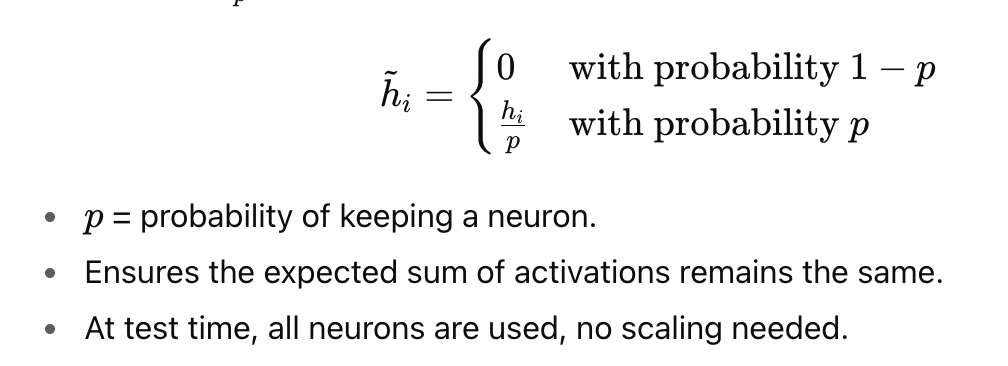

**Effect:** Randomly removes neurons → prevents co-adaptation → robust feature learning.

---


In [7]:
import tensorflow as tf

# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize to [0,1] and reshape
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
X_train = X_train.reshape(-1, 28*28)  # flatten images for fully connected networks
X_test = X_test.reshape(-1, 28*28)

**Explanation:**

- MNIST has **28×28 grayscale images** of digits 0–9.
- Normalization helps **faster and stable training**.
- Flattened for fully connected layers (we can also do CNNs later).

In [9]:
from tensorflow.keras import layers, models

# --- Dropout MLP ---
dropout_model = models.Sequential([
    layers.Dense(256, activation='relu', input_shape=(28*28,)),
    layers.Dropout(0.5),  # 50% neurons dropped
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

# Compile model
dropout_model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

# Train model
dropout_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

# Evaluate
loss, acc = dropout_model.evaluate(X_test, y_test)
print(f"Dropout Model Test Accuracy: {acc:.4f}")

Epoch 1/10


/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8432 - loss: 0.5048 - val_accuracy: 0.9489 - val_loss: 0.1661
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9280 - loss: 0.2479 - val_accuracy: 0.9637 - val_loss: 0.1262
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9426 - loss: 0.1977 - val_accuracy: 0.9678 - val_loss: 0.1121
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9495 - loss: 0.1709 - val_accuracy: 0.9709 - val_loss: 0.1027
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9552 - loss: 0.1518 - val_accuracy: 0.9715 - val_loss: 0.1022
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9593 - loss: 0.1394 - val_accuracy: 0.9739 - val_loss: 0.0903
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9622 - loss: 0.1274 - val_accuracy: 0.9746 - val_loss: 0.0892
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9628 - loss: 0.1231 - val_accuracy: 0.9758 - val_

## **Explanation:**

1. **`layers.Dense(256, activation='relu', input_shape=(28*28,))`**
    - Fully connected layer with **256 neurons**.
    - `relu` activation introduces non-linearity, allowing the network to learn complex patterns.
    - `input_shape=(28*28,)` because MNIST images are flattened 28×28=784 pixels.
2. **`layers.Dropout(0.5)`**
    - During training, **50% of the neurons are randomly “dropped”**.
    - Prevents neurons from **co-adapting**, forcing the network to learn **redundant, robust representations**.
    - At **test time**, dropout is turned off automatically, and all neurons are used.
3. **Second Dense + Dropout**
    - Reduces overfitting further by repeating the same concept.
4. **Output Layer**
    - `Dense(10, activation='softmax')` for **10-class classification**.
    - Softmax outputs probabilities for each digit class.
5. **Training**
    - Optimizer: `adam` → adaptive learning rate for faster convergence.
    - Loss: `sparse_categorical_crossentropy` → used for integer labels in multi-class classification.
    - Metrics: accuracy.

---

## 2. 🧊 Batch Normalization: Normalizing Activations

**What it is**: Batch Normalization (BatchNorm) normalizes the input of each layer so that they have a mean of zero and a variance of one. This is done for each mini-batch during training.

**How it helps**: By normalizing the inputs, BatchNorm reduces the internal covariate shift, leading to faster and more stable training. It also has a slight regularization effect, reducing the need for other regularization techniques.

**Implementation**: In PyTorch, BatchNorm can be applied using `nn.BatchNorm2d(num_features)`, where `num_features` is the number of channels in the input.

**At test time**: The running averages of mean and variance computed during training are used for normalization.

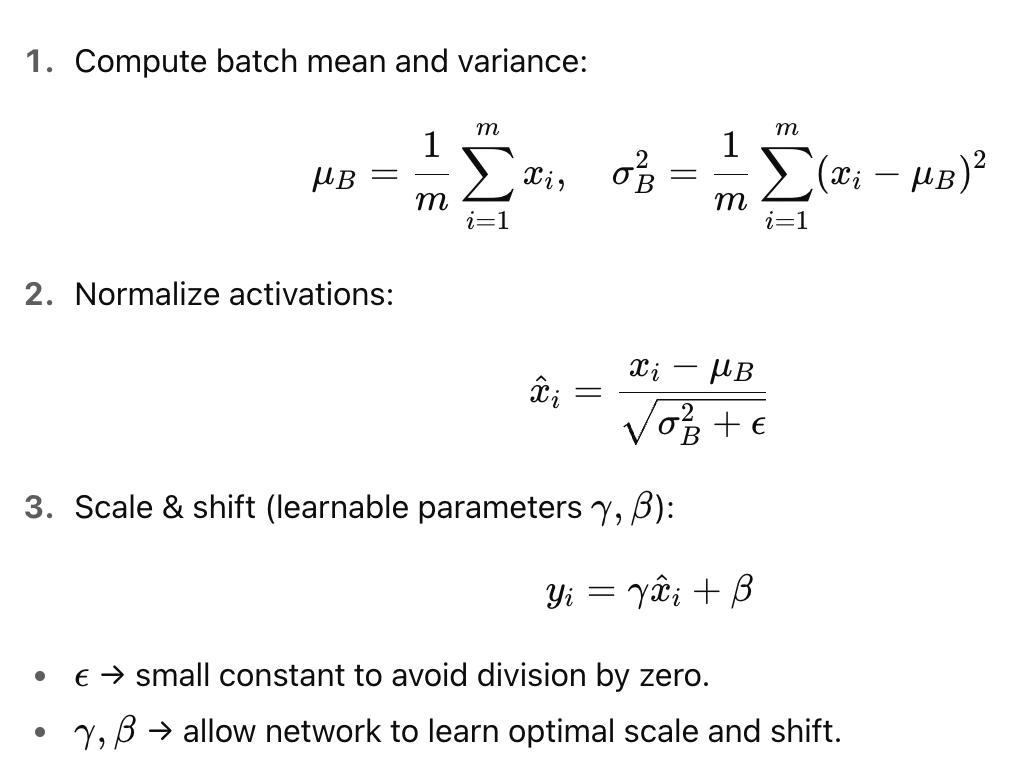

**Effect:** Stabilizes training, reduces internal covariate shift, slightly regularizes the network.

---

In [12]:
# --- BatchNorm MLP ---
bn_model = models.Sequential([
    layers.Dense(256, input_shape=(28*28,)),
    layers.BatchNormalization(),  # normalize activations
    layers.ReLU(),
    layers.Dense(128),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Dense(10, activation='softmax')
])

# Compile model
bn_model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

# Train model
bn_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

# Evaluate
loss, acc = bn_model.evaluate(X_test, y_test)
print(f"BatchNorm Model Test Accuracy: {acc:.4f}")

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9359 - loss: 0.2219 - val_accuracy: 0.9623 - val_loss: 0.1219
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9732 - loss: 0.0881 - val_accuracy: 0.9729 - val_loss: 0.0870
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9810 - loss: 0.0599 - val_accuracy: 0.9748 - val_loss: 0.0849
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9865 - loss: 0.0422 - val_accuracy: 0.9758 - val_loss: 0.0848
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9884 - loss: 0.0362 - val_accuracy: 0.9735 - val_loss: 0.0916
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9907 - loss: 0.0294 - val_accuracy: 0.9758 - val_loss: 0.0839
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9920 - loss: 0.0246 - val_accuracy: 0.9724 - val_loss: 0.0966
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9928 - loss: 0.0218 - val_accuracy: 0.

## **Explanation:**

1. **BatchNorm Layers**
    - **Normalizes activations** in each mini-batch to have mean = 0 and variance = 1.
    - Reduces **internal covariate shift** → the distribution of inputs to layers remains stable.
    - Helps the network **train faster** and sometimes allows higher learning rates.
2. **ReLU Activation after BatchNorm**
    - Applies non-linearity **after normalization** (common practice).
3. **Dense Layers**
    - Similar to the dropout model but **without dropout**.
    - BatchNorm itself acts as a **mild regularizer**, often reducing the need for heavy dropout.
4. **Output Layer**
    - Same 10-class softmax output.
5. **Training**
    - Optimizer: `adam`, Loss: `sparse_categorical_crossentropy`.
    - BatchNorm ensures stable gradients → smoother and faster training.

---

## 3. 🧮 Weight Decay (L2 Regularization): Penalizing Large Weights

**What it is**: Weight Decay adds a penalty to the loss function proportional to the sum of the squared values of the weights. This discourages the model from fitting the noise in the training data by keeping the weights small.

**How it helps**: By penalizing large weights, weight decay prevents the model from becoming overly complex and overfitting the training data.

**Implementation**: In PyTorch, weight decay can be applied by setting the `weight_decay` parameter in the optimizer, e.g., `optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)`.

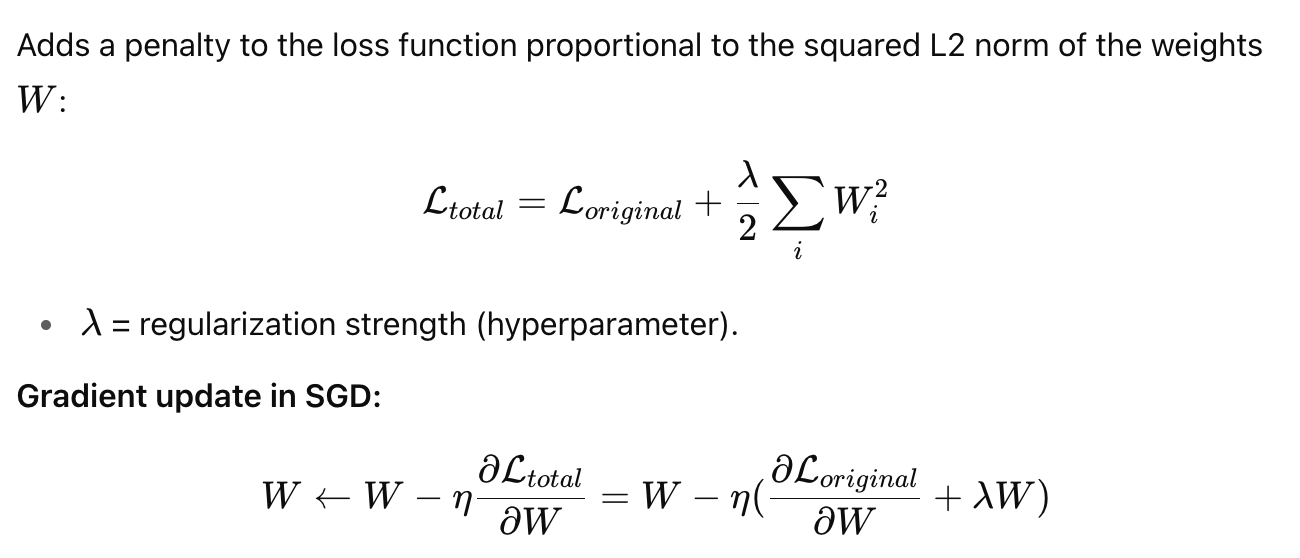

- Penalizes large weights → prevents overfitting.
- Can be combined with Dropout and BatchNorm for stronger regularization.

---

In [16]:
from tensorflow.keras import regularizers

# --- Weight Decay MLP ---
wd_model = models.Sequential([
    layers.Dense(256, activation='relu', input_shape=(28*28,),
                 kernel_regularizer=regularizers.l2(1e-3)),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-3)),
    layers.Dense(10, activation='softmax')
])

# Compile model
wd_model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

# Train model
wd_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

# Evaluate
loss, acc = wd_model.evaluate(X_test, y_test)
print(f"Weight Decay Model Test Accuracy: {acc:.4f}")

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9196 - loss: 0.5520 - val_accuracy: 0.9567 - val_loss: 0.3459
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9594 - loss: 0.3022 - val_accuracy: 0.9576 - val_loss: 0.2854
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9678 - loss: 0.2409 - val_accuracy: 0.9698 - val_loss: 0.2211
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9700 - loss: 0.2155 - val_accuracy: 0.9646 - val_loss: 0.2270
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9725 - loss: 0.1982 - val_accuracy: 0.9687 - val_loss: 0.2096
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9746 - loss: 0.1854 - val_accuracy: 0.9707 - val_loss: 0.1980
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9760 - loss: 0.1759 - val_accuracy: 0.9709 - val_loss: 0.1927
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9769 - loss: 0.1670 - val_accuracy: 0.

## **Explanation:**

1. **`kernel_regularizer=regularizers.l2(1e-3)`**
    - Adds **L2 penalty** to the loss:losstotal=lossoriginal+λ∑Wi2
        
       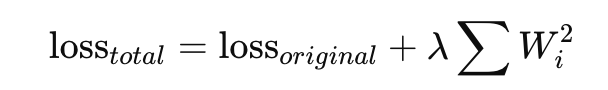
        
    - Encourages **smaller weights**, preventing overfitting.
    - λ=1e−3 is the **regularization strength**.
2. **Dense Layers**
    - Two hidden layers (256 → 128) with ReLU activations.
    - L2 regularization applied to **all weights** in hidden layers.
3. **Output Layer**
    - Dense 10 with softmax for 10-class classification.
4. **Training**
    - Optimizer: `adam` or `sgd` can be used.
    - Loss: `sparse_categorical_crossentropy`.
    - During backpropagation, the gradient of L2 term is added → weights are penalized.

**Effect:**

- The network avoids **overfitting**, especially on smaller datasets or when the network is large.

---

## ✅ Summary: Combining Regularization Techniques

| Technique | Purpose | When to Use |
| --- | --- | --- |
| **Dropout** | Prevents neurons from co-adapting too much | During training to enhance generalization, large networks, prone to overfitting |
| **Batch Normalization** | Normalizes activations to speed up training | In deep networks to stabilize learning, CNNs |
| **Weight Decay** | Penalizes large weights to reduce overfitting | In all models to prevent overfitting, especially fully connected layer |

**Best Practices**:

- **Use Dropout** to prevent overfitting, especially in large networks.
- **Apply Batch Normalization** to stabilize and accelerate training.
- **Implement Weight Decay** to keep the model weights small and prevent overfitting.

By combining these techniques, you can build robust deep CNNs that generalize well to new, unseen data. 

---


## 🤖**Optimizers in Deep Learning**

### **What are optimizers?**

Optimizers are algorithms that **update a neural network’s weights** during training to minimize the loss function. They determine **how the model learns from data** and are crucial for **faster convergence** and **better generalization**. Optimizers **determine the direction and magnitude of weight updates** based on the gradient of the loss function. They play a crucial role in **ensuring that the model converges to a minimum efficiently** rather than getting stuck in local minima or diverging due to large updates. A poor choice of optimizer or learning rate can lead to **slow training, oscillations, or suboptimal solutions**, whereas the right optimizer accelerates convergence and improves generalization to unseen data.

Modern optimizers like **Adam** and **RMSProp** go beyond simple gradient descent by using **adaptive learning rates** for each parameter and considering **momentum**, which helps smooth the update path and prevents overshooting. Additionally, techniques like **learning rate scheduling** allow dynamic adjustment of the learning rate during training, enabling faster learning at the beginning and finer adjustments toward the end.

## 🧠 1. Stochastic Gradient Descent (SGD)

**Overview**:

SGD is a foundational optimization algorithm in machine learning. Unlike traditional gradient descent, which computes gradients using the entire dataset, SGD updates parameters using a single or a few training examples at a time, leading to faster iterations.

**Mathematical Formulation**:

Given a loss function L(θ), the update rule is:

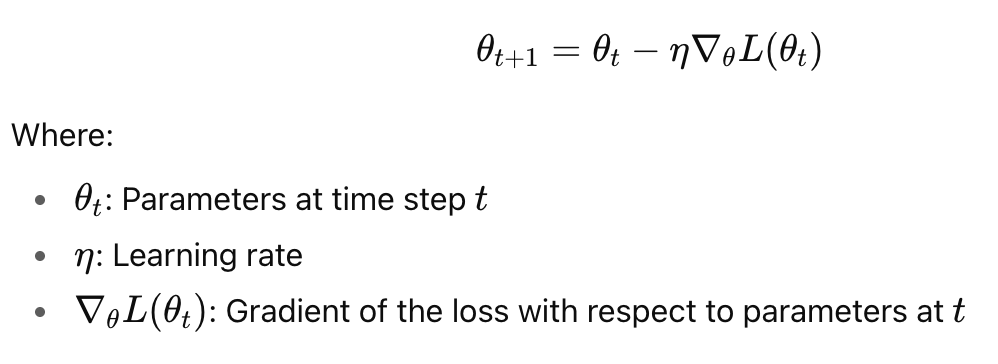

Where:

- θt: Parameters at time step ttt
- η: Learning rate
- ∇θL(θt): Gradient of the loss with respect to parameters at ttt

**Advantages**:

- Faster convergence for large datasets.
- Can escape local minima due to its noisy updates.

**Challenges**:

- High variance in updates can lead to instability.
- Requires careful tuning of the learning rate.

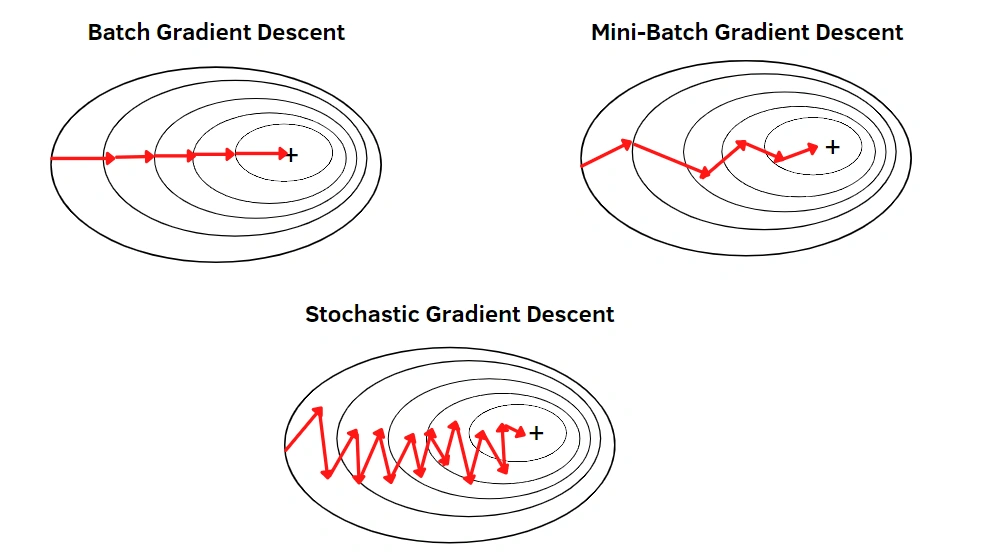

---

In [21]:
import tensorflow as tf

# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train, X_test = X_train/255.0, X_test/255.0
X_train = X_train.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)

# Define model
sgd_model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(28*28,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile with SGD optimizer
sgd_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),  # momentum helps stabilize
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train model
sgd_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

# Evaluate
loss, acc = sgd_model.evaluate(X_test, y_test)
print(f"SGD Test Accuracy: {acc:.4f}")

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8807 - loss: 0.4062 - val_accuracy: 0.9413 - val_loss: 0.2112
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9482 - loss: 0.1768 - val_accuracy: 0.9558 - val_loss: 0.1493
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9624 - loss: 0.1273 - val_accuracy: 0.9635 - val_loss: 0.1262
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9712 - loss: 0.0985 - val_accuracy: 0.9641 - val_loss: 0.1204
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9763 - loss: 0.0812 - val_accuracy: 0.9649 - val_loss: 0.1147
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9804 - loss: 0.0660 - val_accuracy: 0.9707 - val_loss: 0.0966
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9831 - loss: 0.0569 - val_accuracy: 0.9728 - val_loss: 0.0923
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9865 - loss: 0.0469 - val_accuracy: 0.

## **Explanation:**

- **SGD** updates model weights using **gradients from mini-batches**, not the full dataset.
- `momentum=0.9` helps **smooth updates**, preventing oscillations and speeding convergence.
- `learning_rate=0.01` determines **step size** for each weight update.
- Suitable for **large datasets**, but may require careful tuning.

Training and evaluation:

- Model learns patterns in **MNIST images** using mini-batches.
- Accuracy improves as weights are updated iteratively.

---

## 🔄 2. Adam (Adaptive Moment Estimation)

**Overview**:

Adam combines the advantages of two other extensions of SGD: AdaGrad and RMSProp. It computes adaptive learning rates for each parameter by considering both the first moment (mean) and the second moment (uncentered variance) of the gradients.

**Mathematical Formulation**:

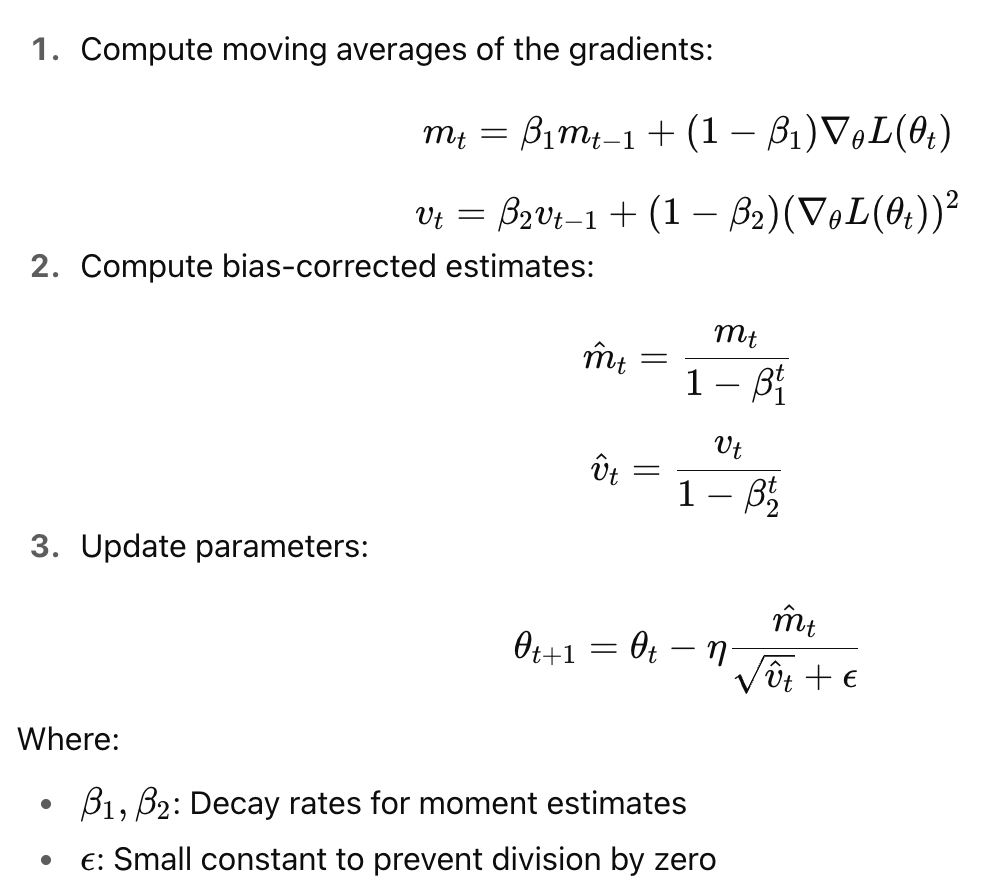

**Advantages**:

- Efficient computation with low memory requirements.
- Well-suited for problems with large datasets and parameters.
- Handles sparse gradients well.

**Challenges**:

- May lead to suboptimal generalization in some cases.
- Requires careful tuning of hyperparameters.

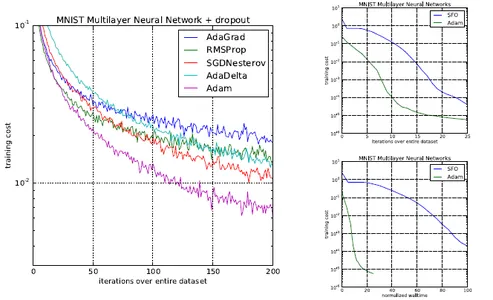

---

In [24]:
# Define model
adam_model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(28*28,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile with Adam
adam_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # default beta1=0.9, beta2=0.999
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train model
adam_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

# Evaluate
loss, acc = adam_model.evaluate(X_test, y_test)
print(f"Adam Test Accuracy: {acc:.4f}")

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9141 - loss: 0.3036 - val_accuracy: 0.9537 - val_loss: 0.1580
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9619 - loss: 0.1278 - val_accuracy: 0.9622 - val_loss: 0.1230
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9731 - loss: 0.0891 - val_accuracy: 0.9707 - val_loss: 0.0985
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9804 - loss: 0.0648 - val_accuracy: 0.9722 - val_loss: 0.0947
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9850 - loss: 0.0503 - val_accuracy: 0.9722 - val_loss: 0.0939
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9874 - loss: 0.0398 - val_accuracy: 0.9723 - val_loss: 0.0953
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9897 - loss: 0.0321 - val_accuracy: 0.9729 - val_loss: 0.0950
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9914 - loss: 0.0260 - val_accuracy: 0.

## **Explanation:**

- **Adam** combines **momentum** (first moment) and **RMSProp** (second moment).
- Maintains **adaptive learning rates** for each weight.
- Less sensitive to initial learning rate than plain SGD.
- Default parameters: `beta1=0.9, beta2=0.999, epsilon=1e-7`.

Training:

- Weights are updated using both the **average gradient** and **variance of gradients**, leading to **faster convergence**.

---

## 📏 3. RMSProp (Root Mean Square Propagation)

**Overview**:

RMSProp is an adaptive learning rate method designed to address the problem of radically diminishing learning rates encountered in AdaGrad. It divides the learning rate by an exponentially decaying average of squared gradients.

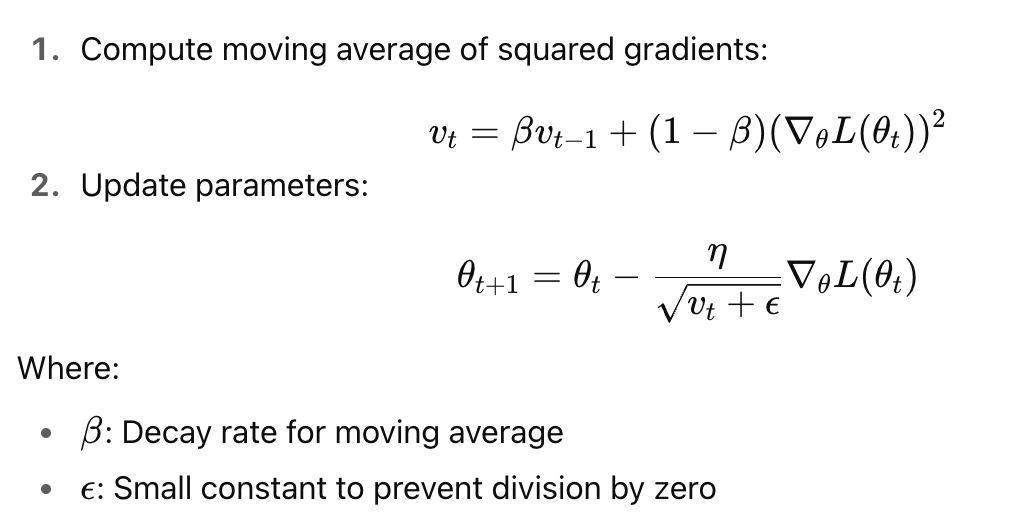

**Advantages**:

- Suitable for non-stationary objectives.
- Effective in online and non-stationary settings.

**Challenges**:

- Requires tuning of the decay rate and learning rate.
- May not perform well on problems with very noisy gradients.

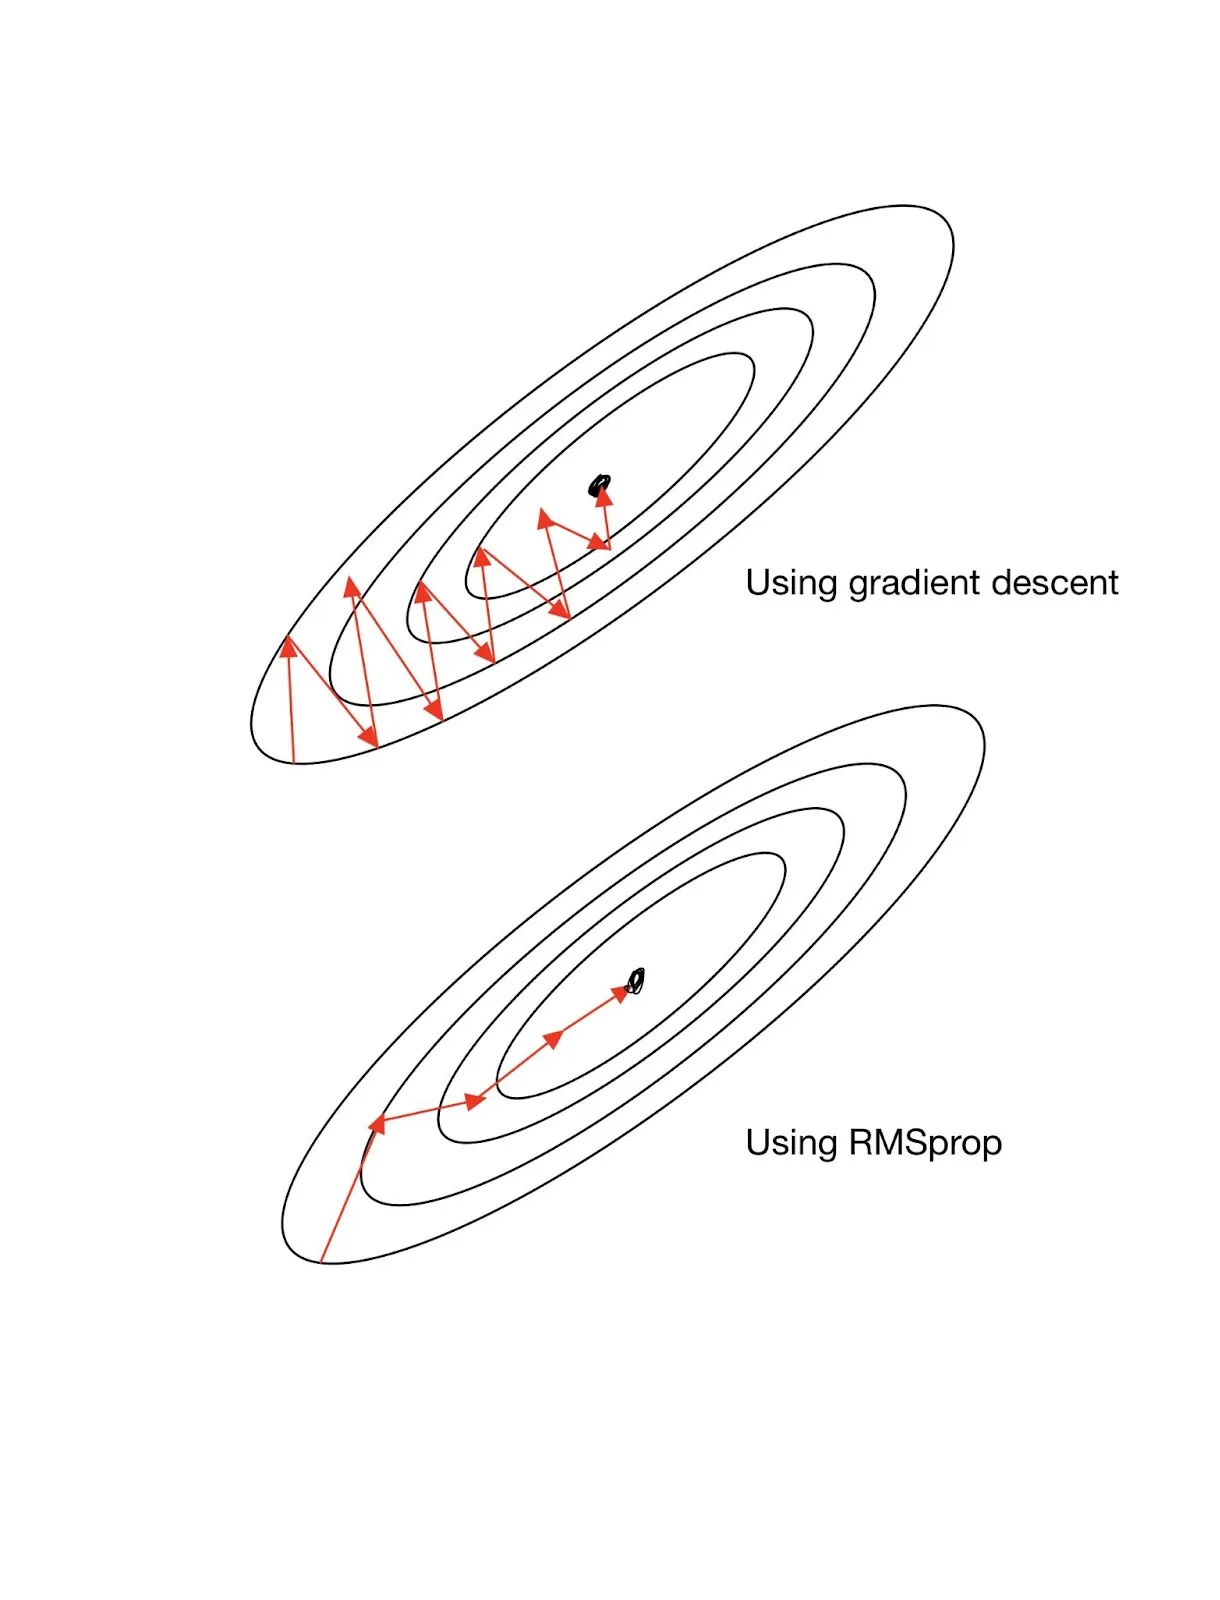

---

In [27]:
# Define model
rms_model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(28*28,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile with RMSProp
rms_model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9),  # rho is decay factor
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train model
rms_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

# Evaluate
loss, acc = rms_model.evaluate(X_test, y_test)
print(f"RMSProp Test Accuracy: {acc:.4f}")

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9146 - loss: 0.2955 - val_accuracy: 0.9557 - val_loss: 0.1497
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9617 - loss: 0.1262 - val_accuracy: 0.9678 - val_loss: 0.1072
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9737 - loss: 0.0872 - val_accuracy: 0.9677 - val_loss: 0.1079
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9793 - loss: 0.0656 - val_accuracy: 0.9698 - val_loss: 0.1034
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9839 - loss: 0.0525 - val_accuracy: 0.9745 - val_loss: 0.0888
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9870 - loss: 0.0417 - val_accuracy: 0.9727 - val_loss: 0.1017
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9892 - loss: 0.0342 - val_accuracy: 0.9753 - val_loss: 0.1002
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9907 - loss: 0.0287 - val_accuracy: 0.

## **Explanation:**

- **RMSProp** divides learning rate by a **moving average of squared gradients**.
- Helps **stabilize updates** when gradients vary a lot.
- `rho=0.9` controls decay of the moving average.
- Especially good for **non-stationary objectives**, e.g., RNNs.

Training:

- Large gradients are scaled down, small gradients scaled up → **stable and adaptive learning**.

---

## 📈 4. Learning Rate Scheduling

**Overview**:

Learning rate scheduling involves adjusting the learning rate during training to improve convergence and generalization. Common strategies include:

- **Step Decay**: Reduces the learning rate by a factor every few epochs.
- **Exponential Decay**: Reduces the learning rate exponentially over time.
- **Cosine Annealing**: Reduces the learning rate following a cosine curve.
- **Cyclical Learning Rates**: Varies the learning rate between a lower and upper bound.

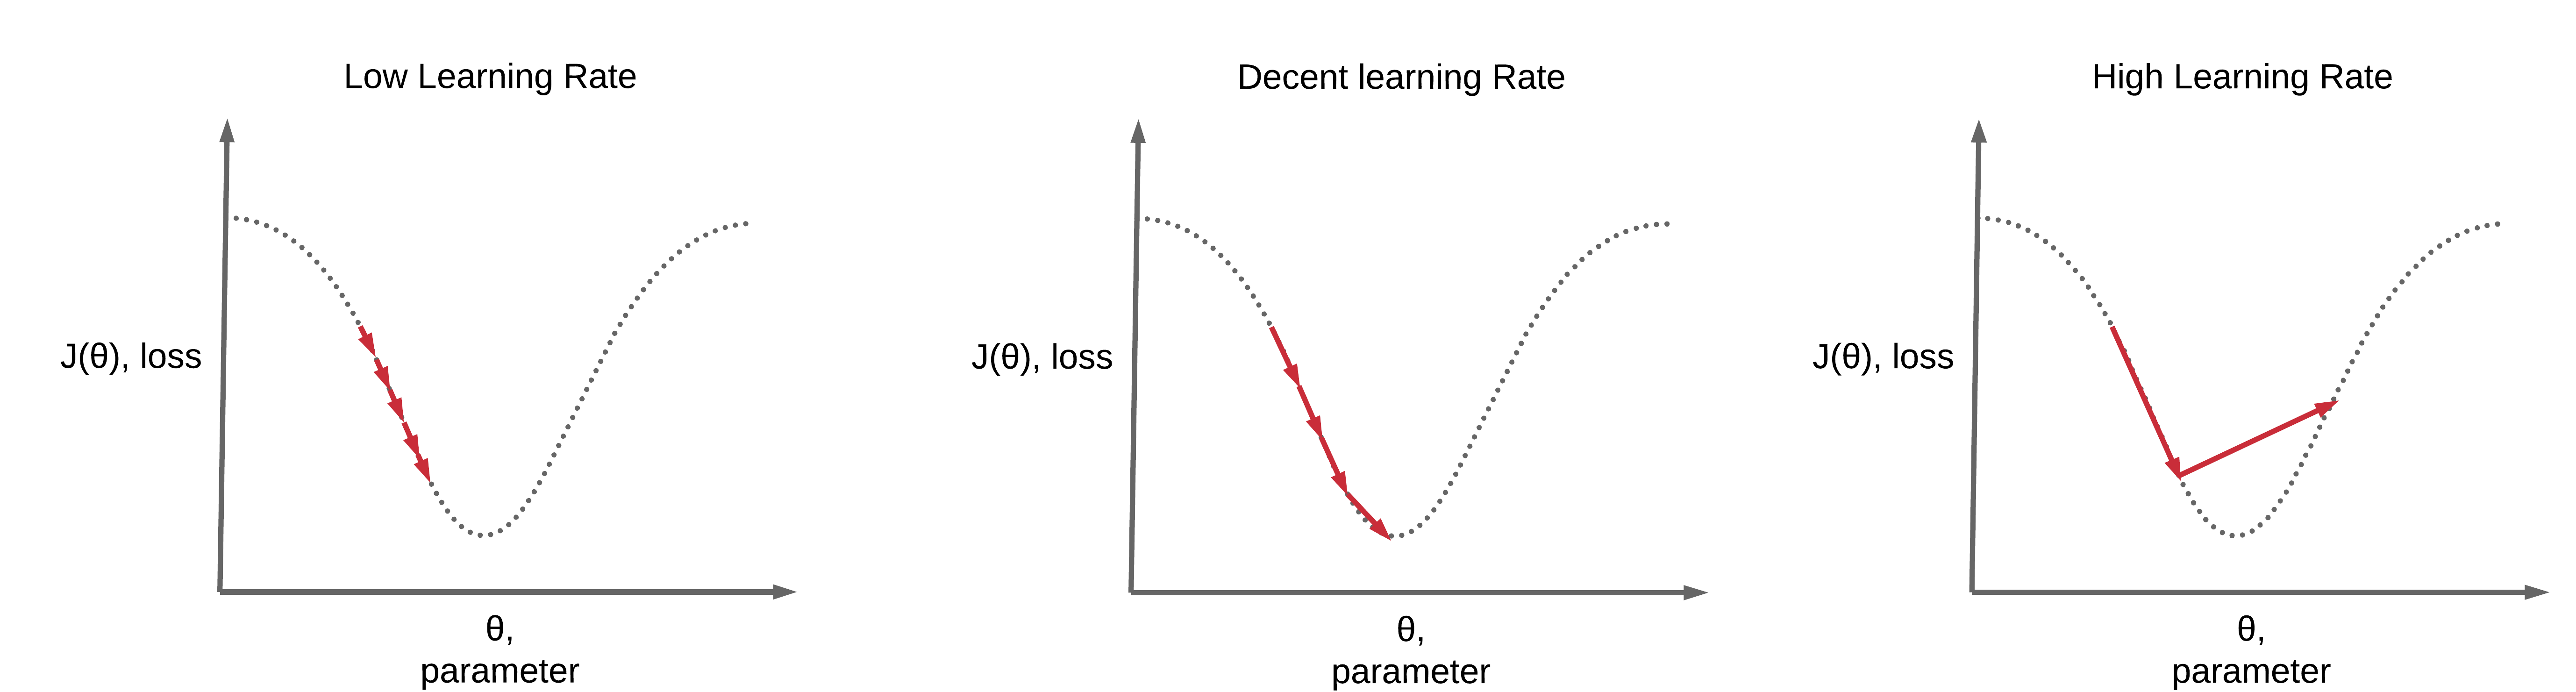

**Mathematical Formulation**:

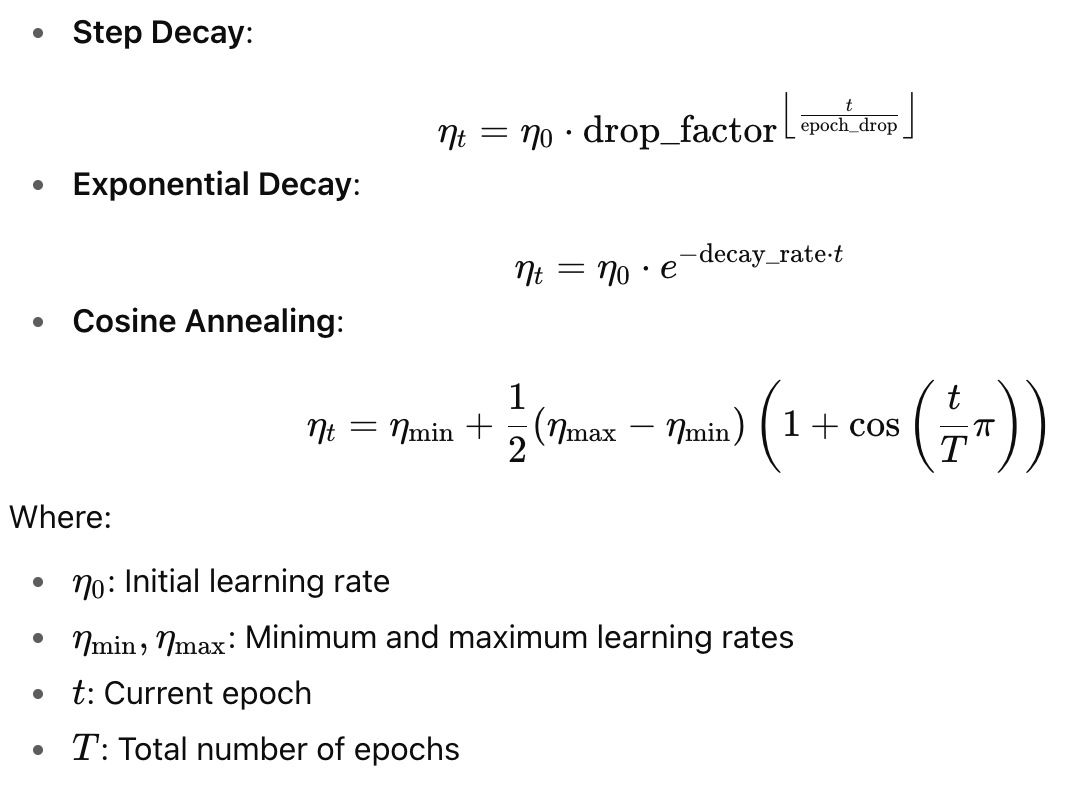

**Advantages**:

- Helps in escaping local minima.
- Can lead to faster convergence.
- Improves generalization by preventing overfitting.

**Challenges**:

- Requires careful selection of the scheduling strategy.
- May need experimentation to find optimal parameters.

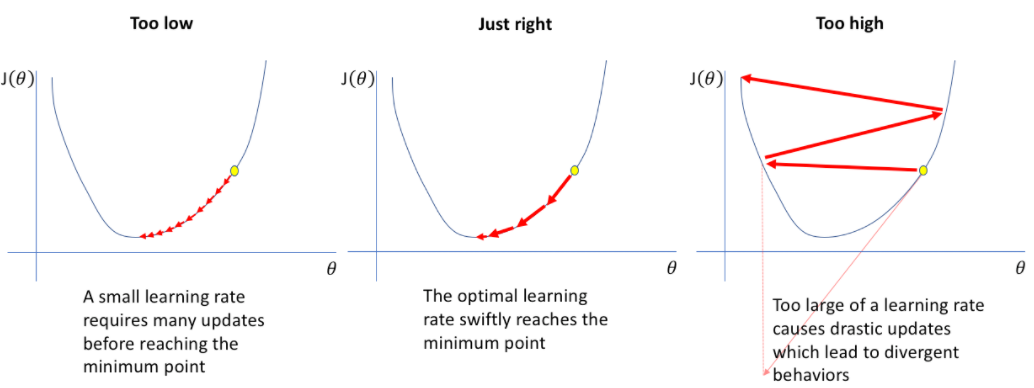

---

In [30]:
# Exponential decay scheduler
initial_lr = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=1000,   # every 1000 steps
    decay_rate=0.96,
    staircase=True
)

# Define model
schedule_model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(28*28,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile with SGD + learning rate schedule
schedule_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train model
schedule_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

# Evaluate
loss, acc = schedule_model.evaluate(X_test, y_test)
print(f"Scheduled LR SGD Test Accuracy: {acc:.4f}")

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8752 - loss: 0.4204 - val_accuracy: 0.9441 - val_loss: 0.2007
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9465 - loss: 0.1811 - val_accuracy: 0.9576 - val_loss: 0.1539
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9620 - loss: 0.1293 - val_accuracy: 0.9629 - val_loss: 0.1336
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9696 - loss: 0.1020 - val_accuracy: 0.9660 - val_loss: 0.1116
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9756 - loss: 0.0834 - val_accuracy: 0.9682 - val_loss: 0.1055
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9794 - loss: 0.0700 - val_accuracy: 0.9711 - val_loss: 0.0947
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9827 - loss: 0.0593 - val_accuracy: 0.9737 - val_loss: 0.0915
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9851 - loss: 0.0499 - val_accuracy: 0.

**Explanation:**

- Reduces learning rate **over time** to avoid overshooting minima.
- `decay_steps=1000` → update learning rate every 1000 steps.
- `decay_rate=0.96` → multiply LR by 0.96 at each step.
- `staircase=True` → learning rate **drops in discrete steps** instead of smoothly.

Training:

- Early in training, **larger LR** helps faster convergence.
- Later, **smaller LR** ensures **fine-tuning** and better generalization.

---

### ✅ **Key Takeaways**

- **SGD**: Simple, robust, but requires tuning. Momentum improves stability.
- **Adam**: Combines momentum + RMSProp; fast convergence; good default choice.
- **RMSProp**: Handles non-stationary gradients well; good for RNNs.
- **Learning Rate Scheduling**: Dynamically reduces LR for **better convergence and generalization**.

---

### ✅ **Summary Table**

| Optimizer / Technique | How it works | Advantages | Use Case |
| --- | --- | --- | --- |
| **SGD** | Updates weights per mini-batch | Simple, robust | Large datasets |
| **Adam** | Combines momentum + adaptive LR | Fast convergence, sparse gradients | Complex models |
| **RMSProp** | Adaptive LR using squared gradient moving average | Stable for varying gradients | RNNs, non-stationary data |
| **Learning Rate Scheduling** | Reduces LR over time | Better convergence & generalization | Any optimizer |

## 🧪 Practical Comparison

| Optimizer | Adaptive Learning Rate | Momentum | Bias Correction | Suitable For |
| --- | --- | --- | --- | --- |
| SGD | No | No | No | Large datasets |
| Adam | Yes | Yes | Yes | Complex models |
| RMSProp | Yes | No | No | Recurrent networks |

---

## 📌 Final Thoughts

- **SGD** is foundational but may require careful tuning and additional techniques like momentum to perform well.
- **Adam** is widely used due to its adaptive learning rates and efficiency.
- **RMSProp** is particularly effective for recurrent neural networks and non-stationary objectives.
- **Learning rate scheduling** can significantly improve training dynamics and model performance.

Understanding and selecting the appropriate optimizer and learning rate schedule is crucial for effective deep learning model training. Experimentation and tuning are often necessary to achieve optimal results.

---

## 🧠 What Is Transfer Learning?

**Transfer Learning** is a machine learning technique where knowledge gained from one task is applied to enhance learning in a related but different task. Instead of training a model from scratch, you leverage a pre-trained model, adapting it to your specific needs. This approach is particularly beneficial when you have limited data for the new task but abundant data for a related task.

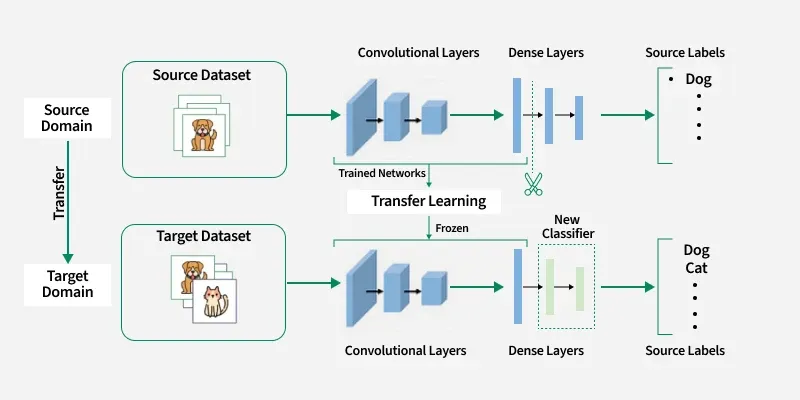

**Key Components:**

- **Source Domain (Dₛ):** The original task or dataset.
- **Target Domain (Dₜ):** The new task or dataset.
- **Source Task (Tₛ):** The learning task associated with Dₛ.
- **Target Task (Tₜ):** The learning task associated with Dₜ.

Transfer learning aims to improve the learning of Tₜ in Dₜ using the knowledge from Tₛ in Dₛ.

---

## 🔄 Types of Transfer Learning

1. **Inductive Transfer Learning:** The source and target tasks are different, but related. The model is adapted to the target task using the knowledge from the source task.
2. **Transductive Transfer Learning:** The source and target tasks are the same, but the domains differ. The model adapts to the target domain using the knowledge from the source domain.
3. **Unsupervised Transfer Learning:** Both the source and target tasks and domains are unsupervised. The model learns from the source data and applies that knowledge to the target data.

---

## 🔧 Fine-Tuning Pretrained Models

**Fine-Tuning** is a specific form of transfer learning where a pre-trained model is further trained (fine-tuned) on a new task. This involves:

- **Freezing** the weights of the initial layers.
- **Training** the later layers on the new task.

Fine-tuning allows the model to adapt its learned features to the new task, improving performance without requiring extensive data.

---

## 📊 Mathematical Perspective

In transfer learning, the goal is to minimize the difference between the source and target tasks. This can be represented as:

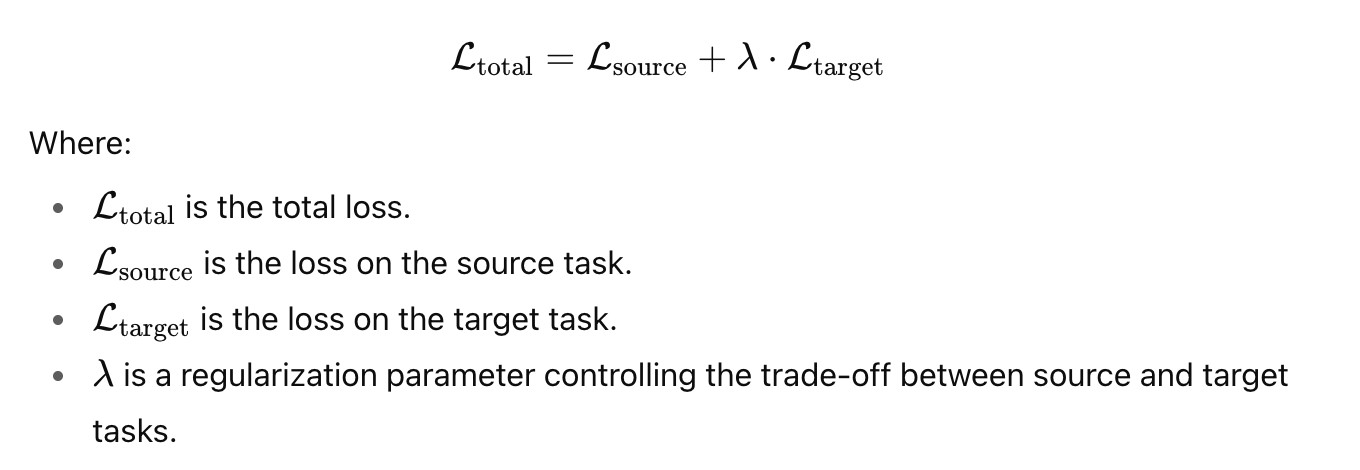

---

## ✅ Benefits of Transfer Learning

- **Reduced Training Time:** Leveraging pre-trained models speeds up the training process.
- **Improved Performance:** Models often achieve higher accuracy due to learned features from large datasets.
- **Resource Efficiency:** Reduces the need for extensive computational resources.
- **Effective with Limited Data:** Particularly useful when the target task has limited labeled data.

---

## ⚠️ Considerations

- **Domain Similarity:** Transfer learning is most effective when the source and target tasks are related.
- **Overfitting Risk:** Fine-tuning on small datasets can lead to overfitting.
- **Model Complexity:** Some pre-trained models may be too complex for simple tasks.

---

## 🧪 Practical Applications

- **Computer Vision:** Image classification, object detection, facial recognition.
- **Natural Language Processing:** Sentiment analysis, language translation, text summarization.
- **Speech Recognition:** Voice command systems, transcription services.
- **Healthcare:** Disease prediction, medical image analysis.

---

## 🛠️ Implementing Transfer Learning

In frameworks like TensorFlow and PyTorch, transfer learning is facilitated through APIs that allow easy loading of pre-trained models and fine-tuning on new tasks. For instance, in TensorFlow:

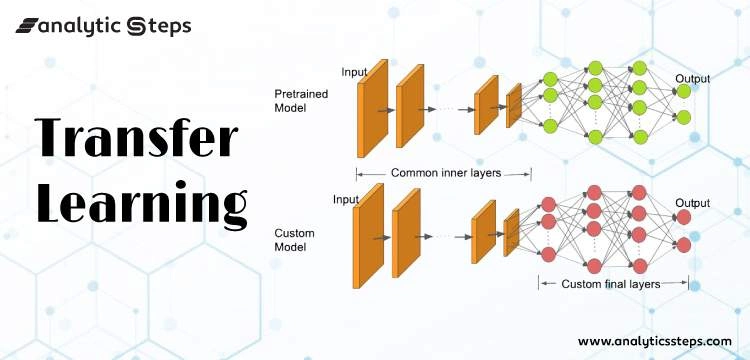

## 🧾 Conclusion

Transfer learning, especially fine-tuning, is a powerful technique that enables the reuse of pre-trained models for new tasks. By understanding and applying transfer learning, you can achieve high-performance models efficiently, even with limited data.

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

Displaying all 6 images from dataset:


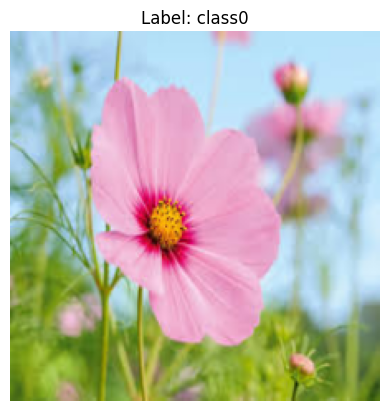

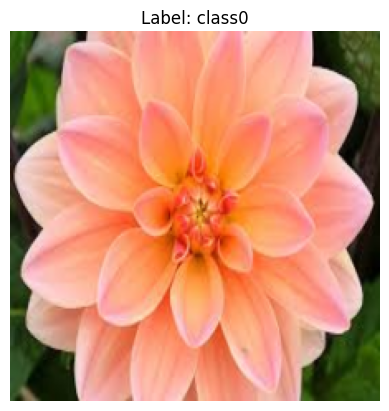

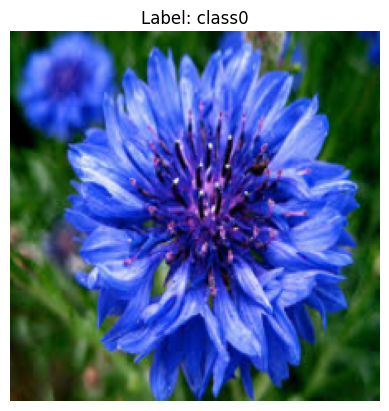

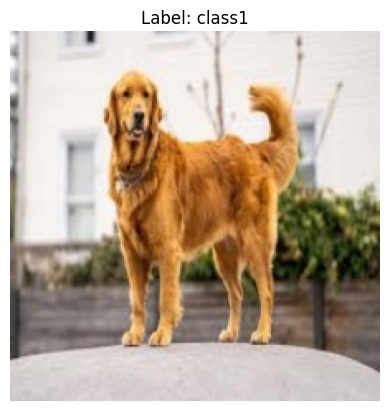

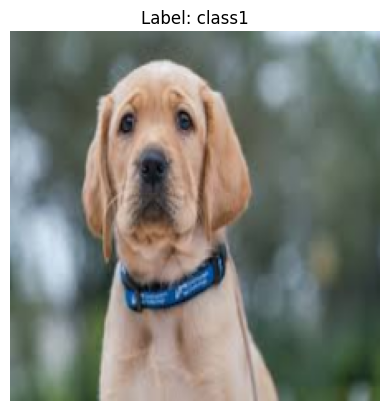

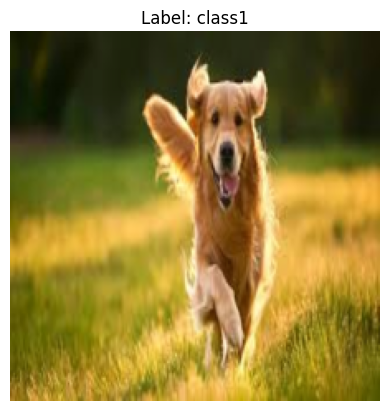

Epoch [1/3], Loss: 0.9423
Epoch [2/3], Loss: 0.9780
Epoch [3/3], Loss: 0.6234
Fine-tuning complete! The model's final layer has been trained for your images.


In [36]:
# 1️⃣ Load Pretrained Model
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Freeze all layers except the final fully connected layer
for param in model.parameters():
    param.requires_grad = False

# Replace the final layer for 2-class classification
model.fc = nn.Linear(model.fc.in_features, 2)


# 2️⃣ Prepare Dataset from Folder
# Transform: resize, convert to tensor, normalize
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Folder structure:
# images/
#    class0/
#       img1.png
#       img2.png
#       img3.png
#    class1/
#       img4.png
#       img5.png
#       img6.png

data_dir = "images"  # Replace with your folder path
train_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# 3️⃣ Display All Images
print(f"Displaying all {len(train_dataset)} images from dataset:")
for i in range(len(train_dataset)):
    img, label = train_dataset[i]
    img = img.permute(1, 2, 0)  # C,H,W -> H,W,C (Channels (3 for RGB: Red, Green, Blue)), Height(pixel), Width(pixel))
    # Unnormalize for display
    img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    img = torch.clamp(img, 0, 1)
    plt.imshow(img)
    plt.title(f"Label: {train_dataset.classes[label]}")
    plt.axis('off')
    plt.show()

# 4️⃣ Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)


# 5️⃣ Training Loop

num_epochs = 3
for epoch in range(num_epochs):
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


# 6️⃣ Model Ready
print("Fine-tuning complete! The model's final layer has been trained for your images.")

## Explanation: 

1. **Load Pretrained Model:** You load **ResNet18** pre-trained on ImageNet. All layers are frozen so their weights don’t change, except the final fully connected layer, which is replaced to classify **2 classes**. This is **fine-tuning**.
2. **Prepare Dataset:** Images are loaded from folders using `ImageFolder`. Each image is resized to 224×224, converted to a tensor, and normalized using ImageNet’s mean and standard deviation. A `DataLoader` creates batches for training and shuffles the data.
3. **Display Images:** Loops through all images, unnormalizes them for proper visualization, and displays each image with its label using `matplotlib`.
4. **Loss & Optimizer:** Uses `CrossEntropyLoss` for classification. The optimizer (SGD) updates **only the final layer’s weights** with a small learning rate and momentum to improve convergence.
5. **Training Loop:** For each epoch, the model predicts outputs for each batch, calculates loss, backpropagates gradients, and updates the final layer’s weights. The loss is printed to monitor training.
6. **Model Ready:** After training, the ResNet18 model is **fine-tuned** for your 2-class dataset and ready for predictions on new images.

---

## **Handling Class Imbalance in Machine Learning**

Class imbalance occurs when certain classes in a dataset are underrepresented compared to others. This imbalance can lead to biased models that favor the majority class, resulting in poor performance on the minority class. Addressing this issue is crucial for building robust and fair machine learning models.

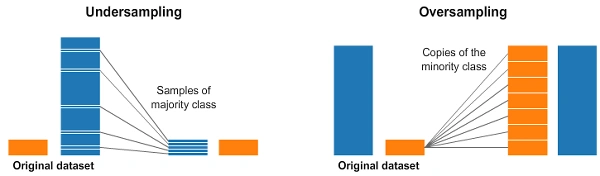

### **1. Resampling Techniques**

Resampling involves modifying the dataset to balance the class distribution.

- #### **Random Oversampling**:
  Increases the number of instances in the minority class by duplicating samples. While simple, it can lead to overfitting due to repeated data.
- #### **Random Undersampling**:
  Reduces the number of instances in the majority class by randomly removing samples. This can lead to loss of important information.
- #### **SMOTE (Synthetic Minority Over-sampling Technique)**:
  Generates synthetic samples for the minority class by interpolating between existing samples. This helps in creating a more generalized decision boundary.
- #### **ADASYN (Adaptive Synthetic Sampling)**:
  An extension of SMOTE that focuses on generating samples for minority class instances that are difficult to classify.
- #### **Tomek Links**:
  Identifies and removes overlapping samples between classes, helping in cleaning the decision boundary.
- #### **SMOTE-Tomek**:
  Combines SMOTE and Tomek Links to both generate synthetic samples and clean the dataset.

---

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

# Apply SMOTE
smote = SMOTE(sampling_strategy=0.5)
X_res, y_res = smote.fit_resample(X_train, y_train)

# Apply Tomek Links
tl = TomekLinks()
X_res, y_res = tl.fit_resample(X_res, y_res)

## Explanation:
- **SMOTE**: Adds synthetic samples to the minority class to balance the dataset.
- **Tomek Links**: Removes overlapping samples to clean the class boundaries.
- **Together**: Balances the dataset **and** makes class separation clearer for better model training.

---

### **2. Algorithm-Level Approaches**

Some algorithms allow for adjustments that make them more sensitive to the minority class.

1. Class Weights / Cost-Sensitive Learning
    - Assigns higher penalty (loss weight) for misclassifying minority class samples.
    - Available in: LogisticRegression(class_weight='balanced'), RandomForestClassifier(class_weight='balanced'), neural nets (custom loss).
    - ✅ Pros: Preserves original dataset structure.
    - ❌ Cons: May overcompensate if weights aren't properly tuned.
2. Threshold Moving
    - Adjusts the default decision threshold (e.g., from 0.5 → 0.3) to favor minority class detection.
    - Use ROC/PR curves to determine the optimal threshold.
    - ✅ Pros: Simple implementation with no data modifications.
    - ❌ Cons: Doesn't address the underlying class imbalance—only shifts prediction bias.
3. Tree-Based Models
    - Decision Trees, Random Forests, XGBoost, and LightGBM handle class imbalance more effectively.
    - Most include built-in parameters like scale_pos_weight.
    - ✅ Pros: Inherently robust to imbalanced data.
    - ❌ Cons: Still requires parameter tuning for severe imbalances.
4. Balanced Bagging / Boosting
    - Example: BalancedBaggingClassifier (from Imbalanced-learn library).
    - Performs internal resampling during the bagging/boosting process.
    - ✅ Pros: Combines the benefits of resampling with ensemble methods.
    - ❌ Cons: Longer training times and increased complexity.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(class_weight='balanced')
model.fit(X_train, y_train)

## Explanation
- **RandomForestClassifier**: An ensemble of decision trees used for classification.
- **class_weight='balanced'**: Automatically assigns **higher weights to minority classes** and lower weights to majority classes, so the model pays more attention to underrepresented classes.
- **model.fit(X_train, y_train)**: Trains the Random Forest on the training data with the adjusted class weights.

**Effect:**

- Helps the model **handle class imbalance** without changing the dataset.
- Improves prediction for **minority classes** while still learning from the majority class.

---

### **3. Cost-Sensitive Learning**

Modifies the learning algorithm to penalize misclassifications of the minority class more heavily.

- **Cost Matrix**: Defines a cost for misclassifying each class. The model aims to minimize the total cost.


In [ ]:
from sklearn.metrics import make_scorer

cost_matrix = [[0, 1], [5, 0]]  # Example cost matrix
cost_scorer = make_scorer(cost_function, cost_matrix=cost_matrix)

## Explanation:
- **cost_matrix**: Defines the penalty for misclassifications (e.g., predicting class 1 as 0 costs more than 0 as 1).
- **make_scorer**: Wraps a custom scoring function so models can use it for evaluation or training.
- **Effect**: Makes the model **focus on avoiding costly errors**, useful for imbalanced or high-risk datasets.

---

### **4. Evaluation Metrics**

Accuracy is not a reliable metric for imbalanced datasets. Alternative metrics include:

- **Precision**: The proportion of positive predictions that are actually correct.
- **Recall**: The proportion of actual positives that are correctly identified.
- **F1-Score**: The harmonic mean of precision and recall.
- **ROC-AUC**: Measures the area under the Receiver Operating Characteristic curve, providing an aggregate measure of performance across all classification thresholds.

---

### **5. Data Augmentation**

In domains like image processing, augmenting the minority class with transformations (e.g., rotations, flips) can help in balancing the dataset.

---

### **6. Ensemble Methods**

Combining multiple models can improve performance on imbalanced datasets.

- **Bagging**: Builds multiple models on different subsets of the data.
- **Boosting**: Focuses on training models that correct the errors of previous ones.
- **Stacking**: Combines multiple models to improve predictions.

---

### **7. Transfer Learning**

Utilizing pre-trained models and fine-tuning them on the specific task can help in scenarios with limited data.

---

### **8. Hybrid Approaches**

Combining multiple techniques can yield better results.

- **SMOTE + Tomek Links**: Generates synthetic samples and cleans the dataset.
- **Ensemble + Cost-Sensitive Learning**: Combines multiple models with adjusted class weights.

---

### **Conclusion**

Handling class imbalance is crucial for building effective machine learning models. The choice of technique depends on the specific problem, dataset, and algorithm used. It's often beneficial to experiment with multiple approaches and evaluate their performance using appropriate metrics.

In [61]:
# Import libraries
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

# -----------------------------
# 1️⃣ Create synthetic imbalanced dataset
# -----------------------------
X, y = make_classification(n_samples=2000, n_features=20, n_informative=10,
                           n_redundant=5, n_clusters_per_class=1,
                           weights=[0.9, 0.1], flip_y=0, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    stratify=y, random_state=42)
print("Original class distribution:", np.bincount(y_train))

# -----------------------------
# 2️⃣ Define the model
# -----------------------------
def create_model(input_dim):
    model = Sequential([
        Dense(64, input_dim=input_dim, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# -----------------------------
# 3️⃣ Function to train and evaluate
# -----------------------------
def train_evaluate(X_train, y_train, X_test, y_test, class_weights=None):
    model = create_model(X_train.shape[1])
    history = model.fit(
        X_train, y_train,
        epochs=30,
        batch_size=32,
        class_weight=class_weights,
        validation_data=(X_test, y_test),
        verbose=0
    )
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    return model

# -----------------------------
# 4️⃣ Approach 1: Train on original imbalanced data
# -----------------------------
print("\n--- Approach 1: Original Data ---")
train_evaluate(X_train, y_train, X_test, y_test)

# -----------------------------
# 5️⃣ Approach 2: SMOTE oversampling
# -----------------------------
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("After SMOTE, class distribution:", np.bincount(y_train_smote))

print("\n--- Approach 2: SMOTE ---")
train_evaluate(X_train_smote, y_train_smote, X_test, y_test)

# -----------------------------
# 6️⃣ Approach 3: Class Weights
# -----------------------------
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: w for i, w in enumerate(class_weights)}
print("\nClass weights:", class_weight_dict)

print("\n--- Approach 3: Class Weights ---")
train_evaluate(X_train, y_train, X_test, y_test, class_weights=class_weight_dict)

# -----------------------------
# 7️⃣ Approach 4: Cost-sensitive loss
# -----------------------------
# Weighted binary crossentropy
def weighted_binary_crossentropy(pos_weight):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        weight_vector = y_true * pos_weight + (1 - y_true)
        return tf.reduce_mean(bce * weight_vector)
    return loss

# pos_weight is ratio of majority/minority class
pos_weight = (np.sum(y_train==0) / np.sum(y_train==1))
print("\nPositive class weight for cost-sensitive loss:", pos_weight)

model_cost = create_model(X_train.shape[1])
model_cost.compile(optimizer=Adam(0.001),
                   loss=weighted_binary_crossentropy(pos_weight),
                   metrics=['accuracy'])
print("\n--- Approach 4: Cost-Sensitive Loss ---")
history = model_cost.fit(X_train, y_train,
                         epochs=30,
                         batch_size=32,
                         validation_data=(X_test, y_test),
                         verbose=0)

y_pred_prob = model_cost.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# -----------------------------
# 8️⃣ Approach 5: SMOTE + Class Weights
# -----------------------------
print("\n--- Approach 5: SMOTE + Class Weights ---")
train_evaluate(X_train_smote, y_train_smote, X_test, y_test, class_weights=class_weight_dict)

Original class distribution: [1260  140]

--- Approach 1: Original Data ---


/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Confusion Matrix:
 [[537   3]
 [  2  58]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       540
           1       0.95      0.97      0.96        60

    accuracy                           0.99       600
   macro avg       0.97      0.98      0.98       600
weighted avg       0.99      0.99      0.99       600

After SMOTE, class distribution: [1260  630]

--- Approach 2: SMOTE ---


/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Confusion Matrix:
 [[537   3]
 [  2  58]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       540
           1       0.95      0.97      0.96        60

    accuracy                           0.99       600
   macro avg       0.97      0.98      0.98       600
weighted avg       0.99      0.99      0.99       600


Class weights: {0: np.float64(0.5555555555555556), 1: np.float64(5.0)}

--- Approach 3: Class Weights ---


/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Confusion Matrix:
 [[535   5]
 [  1  59]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       540
           1       0.92      0.98      0.95        60

    accuracy                           0.99       600
   macro avg       0.96      0.99      0.97       600
weighted avg       0.99      0.99      0.99       600


Positive class weight for cost-sensitive loss: 9.0

--- Approach 4: Cost-Sensitive Loss ---


/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Confusion Matrix:
 [[533   7]
 [  0  60]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       540
           1       0.90      1.00      0.94        60

    accuracy                           0.99       600
   macro avg       0.95      0.99      0.97       600
weighted avg       0.99      0.99      0.99       600


--- Approach 5: SMOTE + Class Weights ---


/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Confusion Matrix:
 [[532   8]
 [  0  60]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       540
           1       0.88      1.00      0.94        60

    accuracy                           0.99       600
   macro avg       0.94      0.99      0.97       600
weighted avg       0.99      0.99      0.99       600



<Sequential name=sequential_11, built=True>

## **Explanation**

### **1️⃣ Data Creation**

- We use `make_classification` to generate a **synthetic binary dataset**.
- `weights=[0.9, 0.1]` creates a **heavily imbalanced dataset** with 90% majority class and 10% minority class.
- `train_test_split` with `stratify=y` ensures the **train and test sets maintain the same imbalance ratio**.

---

### **2️⃣ Model Definition**

- `create_model()` defines a **simple feedforward neural network**:
    - **Dense layers:** 64 → 32 → 1 node (sigmoid activation for binary classification).
    - **Dropout layers:** Reduce overfitting.
- Optimizer: `Adam` with `learning_rate=0.001`.
- Loss: `binary_crossentropy` by default.

---

### **3️⃣ Training Function**

- `train_evaluate()` trains the model on provided training data.
- Optional **class_weights** argument lets the model **focus more on minority class**.
- After training, predictions are made and evaluated with:
    - **Confusion matrix** → shows true vs predicted labels.
    - **Classification report** → shows precision, recall, F1-score.

---

### **4️⃣ Approaches for Handling Class Imbalance**

1. **Original Data**
    - Train the model directly on the imbalanced dataset.
    - Likely to **favor majority class**, poor performance on minority class.
2. **SMOTE Oversampling**
    - `SMOTE` generates **synthetic samples for minority class**.
    - Balances the dataset, improving recall and F1-score for minority class.
3. **Class Weights**
    - Computes **weights inversely proportional to class frequency**.
    - During training, minority class errors are **penalized more**, improving model attention to minority class.
4. **Cost-Sensitive Loss**
    - Custom **weighted binary crossentropy** assigns **higher loss to misclassifying minority class**.
    - Useful for scenarios where minority errors are **more critical**.
5. **SMOTE + Class Weights**
    - Combines **data-level balancing** (SMOTE) and **algorithm-level weighting**.
    - Often results in the **best performance** for imbalanced datasets.

---

### **5️⃣ Evaluation**

- After each approach, we evaluate using:
    - **Confusion matrix** → checks predictions for both classes.
    - **Classification report** → key metrics (precision, recall, F1-score) for both classes.
- This allows **comparing performance across different strategies**.

---

### **Summary**

- The code demonstrates **five different strategies** for handling class imbalance in deep learning:
    1. Original data
    2. SMOTE oversampling
    3. Class weights
    4. Cost-sensitive loss
    5. SMOTE + Class weights
- It shows how **data-level techniques, algorithm-level adjustments, and loss-level modifications** can improve minority class performance.
  
---

# Advanced Topics

# CNN-based Autoencoder Architecture
A **Convolutional Autoencoder (CAE)** is a specialized type of autoencoder that leverages Convolutional Neural Networks (CNNs) for encoding and decoding, making it particularly effective for image-related tasks such as denoising, anomaly detection, and dimensionality reduction. Unlike traditional autoencoders that use fully connected layers, CAEs utilize convolutional layers to capture spatial hierarchies and local patterns in images.

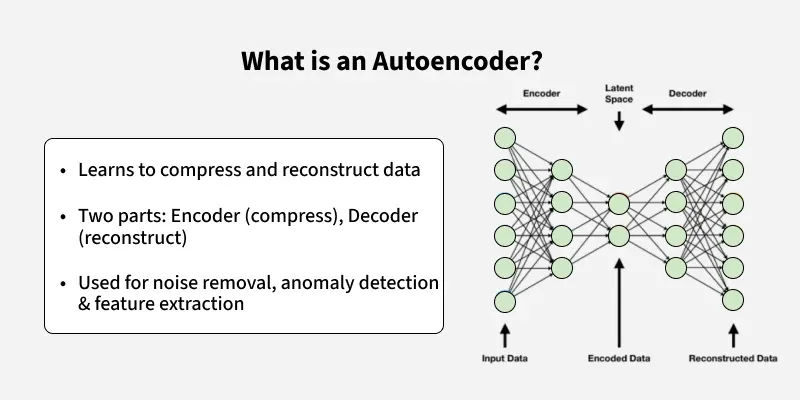
---

## 🧱 Architecture Overview

A Convolutional Autoencoder typically consists of three main components:

1. **Encoder**: This part compresses the input image into a latent-space representation. It uses a series of convolutional layers, often interspersed with activation functions like ReLU and pooling layers, to progressively reduce the spatial dimensions of the input while extracting essential features.
2. **Bottleneck (Latent Space)**: The central layer that holds the compressed knowledge of the input data. It represents the most compact form of the input's features, capturing the underlying structure in a lower-dimensional space.
3. **Decoder**: This segment reconstructs the input image from the compressed representation. It employs transposed convolutional layers (also known as deconvolutional layers) to upsample the latent representation back to the original image dimensions.

The architecture is symmetric, meaning the encoder and decoder mirror each other in terms of layer types and dimensions.

---

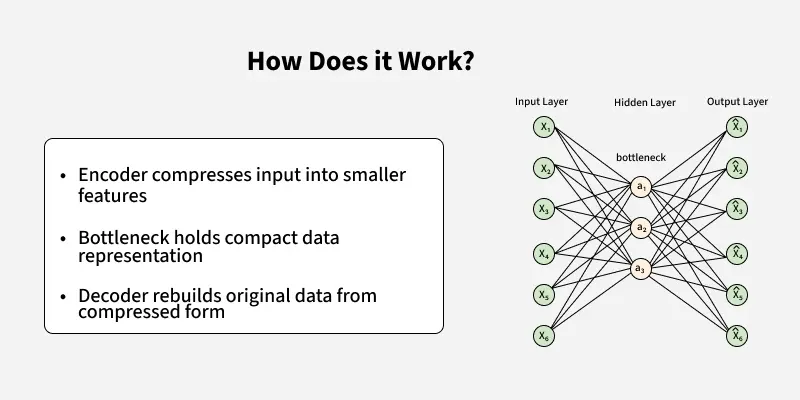

## 🔧 Mathematical Operations

The core operations in a Convolutional Autoencoder include:

- **Convolution**: Applies a filter (kernel) to the input to create feature maps, capturing spatial hierarchies.
    
   $ Output=ReLU(Conv2D(X,W)+b)$    
    Where X is the input, W is the filter, and b is the bias term.
    
- **Pooling**: Reduces the spatial dimensions (height and width) of the feature maps, typically using max pooling.
    
    $Output=MaxPool2D(X)$
    
- **Transposed Convolution (Deconvolution)**: Upsamples the feature maps to reconstruct the input dimensions.Output=Conv2DTranspose(X,W)
    
   $ Output=Conv2DTranspose(X,W)$

These operations enable the model to learn spatial hierarchies and reconstruct high-quality images from compressed representations.

---

## 🧪 Applications

Convolutional Autoencoders are versatile and can be applied in various domains:

- **Image Denoising**: By training on noisy images, CAEs can learn to reconstruct clean versions, effectively removing noise.
- **Anomaly Detection**: Since CAEs learn the distribution of normal data, they can identify anomalies by measuring reconstruction errors.
- **Dimensionality Reduction**: The bottleneck layer serves as a compressed representation, useful for tasks like clustering and visualization.
- **Image Generation**: By sampling from the latent space, CAEs can generate new images that resemble the training data.

In [65]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_cae(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Bottleneck
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    # Decoder
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)

    model = models.Model(inputs, decoded)
    model.compile(optimizer='adam', loss='binary_crossentropy')
    return model

# Example usage
input_shape = (28, 28, 1)  # Example for grayscale images
cae = build_cae(input_shape)
cae.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 7, 7, 64)       │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 14, 14, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 185,217 (723.50 KB)

 Trainable params: 185,217 (723.50 KB)

 Non-trainable params: 0 (0.00 B)

## Explanation:
1. **Imports:** Uses TensorFlow/Keras to build the model.
2. **Input:** `Input(shape=input_shape)` defines the image size (e.g., 28×28×1 for grayscale).
3. **Encoder:**
    - `Conv2D` layers extract features.
    - `MaxPooling2D` reduces spatial dimensions, compressing the image.
4. **Bottleneck:**
    - `Conv2D(128)` compresses features into a latent representation.
5. **Decoder:**
    - `Conv2DTranspose` and `UpSampling2D` layers reconstruct the image to original size.
    - Final `Conv2DTranspose(1, activation='sigmoid')` outputs the reconstructed grayscale image.
6. **Compile:**
    - `optimizer='adam'` updates weights efficiently.
    - `loss='binary_crossentropy'` measures reconstruction error.
7. **Usage:**
    - `build_cae(input_shape)` creates the model.
    - `summary()` shows the architecture and parameters.

**Purpose:** Compress and reconstruct images for tasks like **denoising, anomaly detection, or dimensionality reduction**.

---

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from keras.datasets import mnist

- `numpy` → array operations.
- `matplotlib.pyplot` → to visualize images.
- `tensorflow.keras` → build and train neural networks.
- `mnist` → dataset of handwritten digits (28x28 grayscale images).

In [69]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

- Load **MNIST dataset**; we ignore labels (`_`) because autoencoders are unsupervised.
- Normalize pixel values to [0, 1].
- Reshape to `(batch_size, height, width, channels)` → CNN/keras-friendly format.


In [71]:
class SimpleAutoencoder(Model):
    def __init__(self, latent_dimensions):
        super(SimpleAutoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(28, 28, 1)),
            layers.Flatten(),
            layers.Dense(latent_dimensions, activation='relu'),
        ])
        
        self.decoder = tf.keras.Sequential([
            layers.Dense(28 * 28, activation='sigmoid'),
            layers.Reshape((28, 28, 1))
        ])
    
    def call(self, input_data):
        encoded = self.encoder(input_data)
        decoded = self.decoder(encoded)
        return decoded


### **Encoder**

- Flattens 28x28 image → 784 vector.
- Dense layer → compresses into **latent vector** of size `latent_dimensions` (64 here).
- `relu` activation → introduces non-linearity.

### **Decoder**

- Takes latent vector → fully connected layer with 784 neurons.
- `sigmoid` activation → outputs values in [0,1] to reconstruct image pixels.
- Reshape → back to `(28,28,1)` image.

### **Forward pass (`call`)**

- Pass input through encoder → latent vector → decoder → reconstructed image.

In [73]:
latent_dimensions = 64
autoencoder = SimpleAutoencoder(latent_dimensions)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

- `latent_dimensions = 64` → size of compressed representation.
- `optimizer='adam'` → gradient-based optimization.
- `loss=MeanSquaredError` → measures reconstruction error (difference between input and output).

In [75]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0597 - val_loss: 0.0318
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0257 - val_loss: 0.0204
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0178 - val_loss: 0.0149
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0134 - val_loss: 0.0114
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0104 - val_loss: 0.0092
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0085 - val_loss: 0.0076
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0072 - val_loss: 0.0066
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0064 - val_loss: 0.0059
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0058 - val_loss: 0.0054
Epoch 10/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0053 - val_loss: 0.0050


- Input = Output (`x_train`) → unsupervised learning.
- `epochs=10` → number of training passes over the dataset.
- `batch_size=256` → number of images per gradient update.
- `shuffle=True` → randomize order of images each epoch.
- `validation_data` → monitor performance on unseen data.

In [77]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

- `encoded_imgs` → compressed latent representations.
- `decoded_imgs` → reconstructed images from latent vectors.

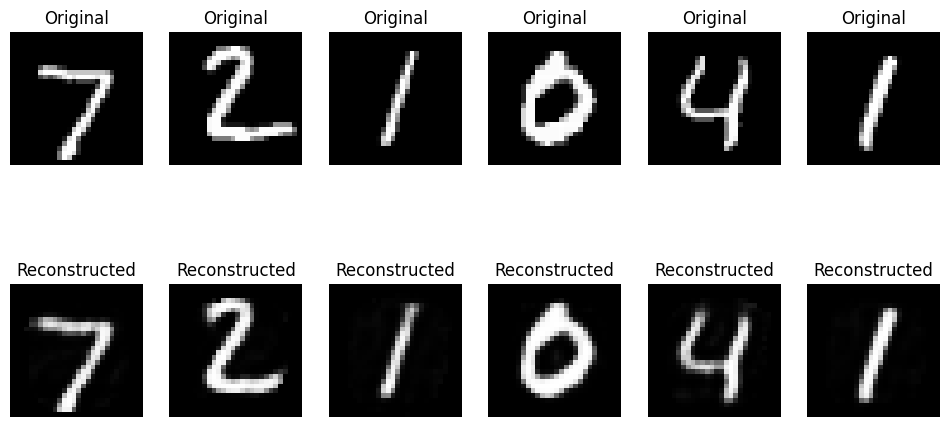

In [79]:
n = 6
plt.figure(figsize=(12, 6))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.show()

- Plots **first 6 test images** side by side with their reconstructions.
- Top row → original images.
- Bottom row → reconstructed images from the autoencoder.
- Allows you to **visually assess reconstruction quality**.

---

### ✅ **Summary**

1. Autoencoder **compresses data** into a latent space (encoder) and then **reconstructs it** (decoder).
2. Training **minimizes reconstruction loss** (MSE).
3. Visualization helps check if the network is **learning meaningful representations**.

---

# **Segmentation & Detection in Computer Vision**

Object detection and segmentation are core tasks in computer vision:

- **Object Detection**: Locate objects in an image and classify them.
- **Segmentation**: Label each pixel as belonging to a class.
    - **Semantic Segmentation**: Every pixel is classified, but instances are not distinguished (e.g., all cars are labeled the same).
    - **Instance Segmentation**: Each object instance is individually labeled (e.g., car 1, car 2).

Modern deep learning models tackle these tasks with CNN-based architectures.

---

## **1. R-CNN (Regions with CNN Features)**

**Introduced by**: Ross Girshick et al., 2014.

**Type**: Two-stage detector (region proposal + classification).

**Workflow**:

1. **Region Proposal**: Uses **Selective Search** to generate ~2000 candidate regions (object proposals).
2. **Feature Extraction**: Each region is warped to a fixed size and passed through a CNN (AlexNet or VGG) to extract features.
3. **Classification**: Extracted features are classified using SVMs into object categories or background.
4. **Bounding Box Regression**: Optional step to refine the predicted bounding boxes.

**Advantages**:

- First CNN-based object detector, improved accuracy over traditional methods like HOG+SVM.

**Limitations**:

- **Slow**: Each region is passed separately through CNN → massive redundant computation.
- **Multi-stage training**: CNN, SVM, and bounding box regression are trained separately.
- **Not end-to-end**.

**Use case**: Basic object detection research; rarely used in production due to speed.

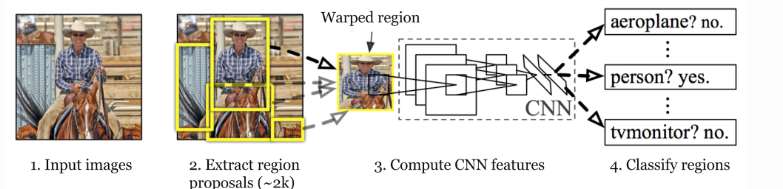

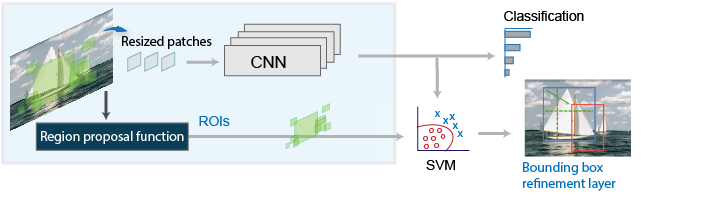
---

## **2. Fast R-CNN**

**Introduced by**: Ross Girshick, 2015.

**Type**: Two-stage detector with shared CNN features.

**Key Improvement**: Instead of running CNN on each region, the entire image is processed **once**.

**Workflow**:

1. **CNN Backbone**: Input image → CNN → feature map.
2. **RoI Pooling**: Map proposals onto the feature map. Extract fixed-size feature vectors (e.g., 7x7) for each region.
3. **Fully Connected Layers**: Feature vectors → classification (softmax) and bounding box regression.

**Advantages**:

- **Shared computation**: Faster than R-CNN (~10x speedup).
- **End-to-end training**: Single network for classification and bounding box regression.
- High accuracy with less computation.

**Limitations**:

- Still relies on **external region proposals** (Selective Search) → bottleneck.

**Use case**: Object detection where accuracy is important and moderate speed is acceptable.

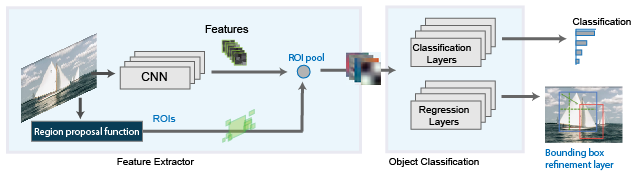

---

## **3. Faster R-CNN**

**Introduced by**: Shaoqing Ren et al., 2015.

**Type**: Two-stage detector with Region Proposal Network (RPN).

**Key Improvement**: Eliminates external proposal algorithms by integrating a **learnable region proposal network**.

**Architecture**:

1. **CNN Backbone**: Extract feature map from the image.
2. **Region Proposal Network (RPN)**: Sliding-window network on feature map generates **object proposals** with objectness scores.
3. **RoI Pooling / RoI Align**: Extract fixed-size features for proposals.
4. **Head Network**: Classifies each proposal and refines bounding boxes.

**Advantages**:

- Fully **end-to-end trainable**.
- Faster than Fast R-CNN + Selective Search.
- High accuracy; standard for research benchmarks (e.g., COCO dataset).

**Limitations**:

- Computationally heavier than single-stage detectors.
- Real-time deployment is challenging without optimization.

**Use case**: High-accuracy object detection, instance-level detection research.

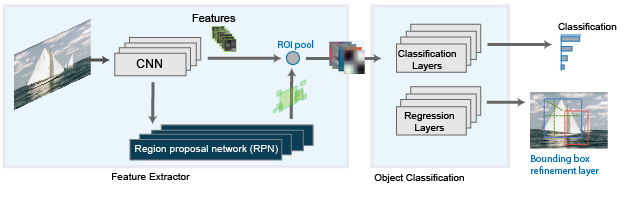

---

## **4. YOLO (You Only Look Once)**

**Introduced by**: Joseph Redmon et al., 2016.

**Type**: Single-stage, real-time object detector.

**Key Idea**: Frame detection as a **regression problem** instead of proposal + classification.

**Workflow**:

1. Divide image into an **SxS grid**.
2. Each grid cell predicts:
    - B bounding boxes (x, y, width, height)
    - Confidence score for object presence
    - Class probabilities
3. Apply **Non-Maximum Suppression (NMS)** to remove overlapping boxes.

**Advantages**:

- Extremely **fast** (real-time: 45+ FPS for YOLOv3).
- Unified architecture → simple and elegant.
- End-to-end trainable.

**Limitations**:

- Lower accuracy for small objects.
- Coarse localization compared to two-stage detectors.

**Variants**:

- **YOLOv3, YOLOv4, YOLOv5, YOLOv8** → Improved accuracy and speed.

**Use case**: Autonomous driving, surveillance, robotics, real-time applications.

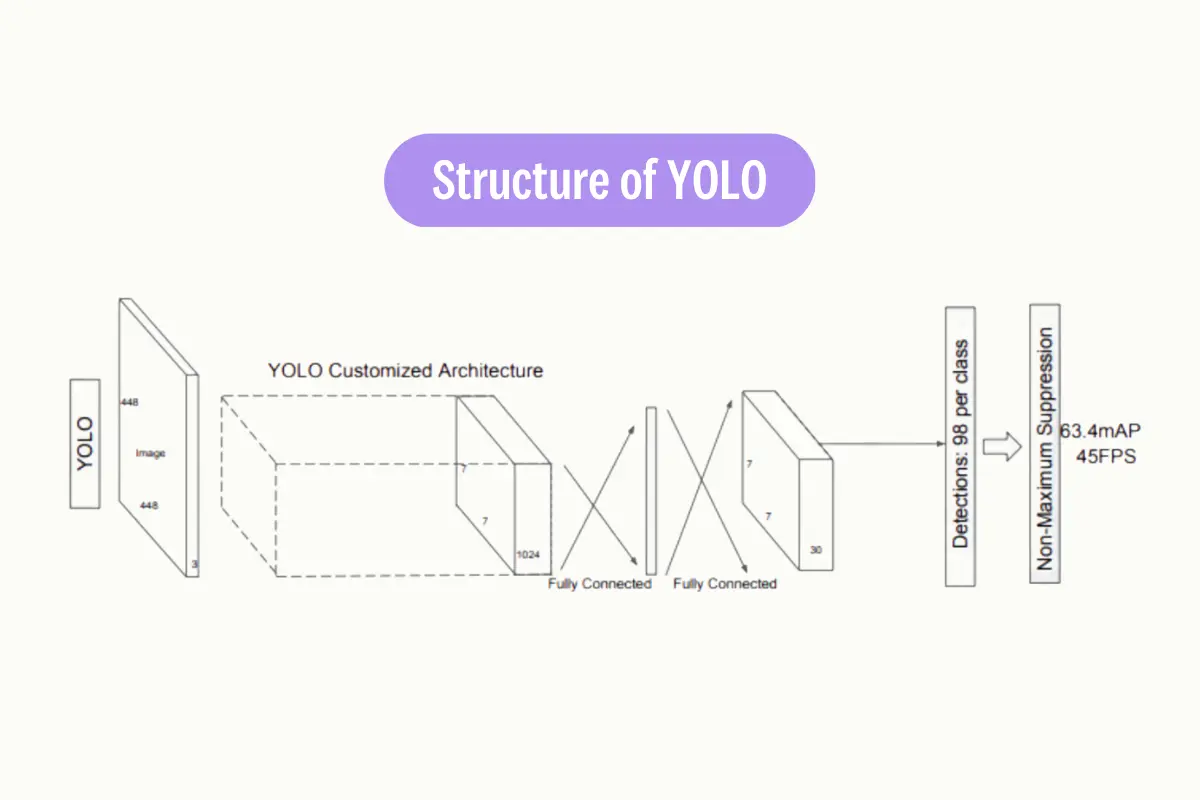
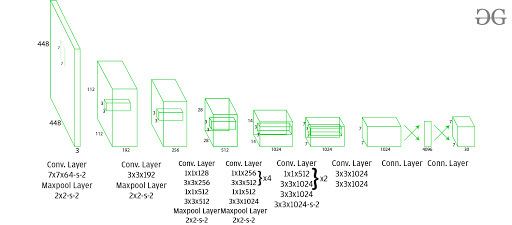

---

## **5. SSD (Single Shot Multibox Detector)**

**Introduced by**: Wei Liu et al., 2016.

**Type**: Single-stage, real-time detector.

**Key Idea**: Predicts bounding boxes and class probabilities from multiple **feature maps** of different resolutions → detects objects at multiple scales.

**Workflow**:

1. Extract feature maps at different layers of a CNN.
2. For each feature map:
    - Define **default boxes** (anchors) of various sizes/aspect ratios.
    - Predict **offsets** to default boxes + class probabilities.
3. Apply NMS for final detections.

**Advantages**:

- Good **speed-accuracy tradeoff**.
- Detects **small and large objects** by using multiple feature maps.
- Real-time (~59 FPS on SSD300).

**Limitations**:

- Less accurate than two-stage detectors like Faster R-CNN for complex datasets.
- Anchor box tuning is critical.

**Use case**: Mobile apps, real-time detection, embedded systems.

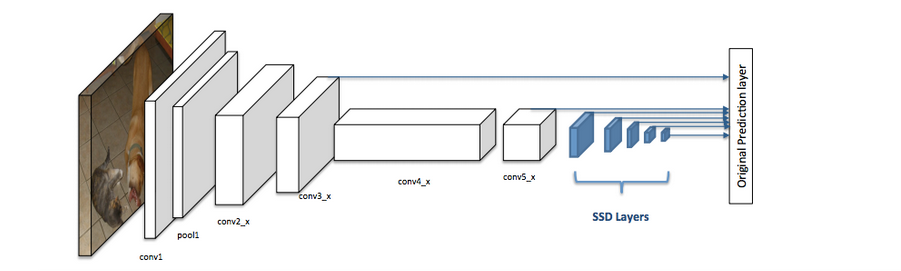

## **6. U-Net**

**Introduced by**: Olaf Ronneberger et al., 2015 (biomedical imaging).

**Type**: Semantic segmentation network.

**Architecture**:

- **Contracting Path**: Repeated conv + ReLU + max-pooling → captures **context**.
- **Bottleneck**: Connects contracting and expanding paths.
- **Expanding Path**: Up-conv + concatenation with feature maps from contracting path → precise localization.

**Key Feature**: **Skip connections** transfer high-resolution features to expanding path → preserves detail.

**Advantages**:

- Works well on **small datasets**.
- Very accurate segmentation.
- End-to-end trainable.

**Limitations**:

- Not designed for instance segmentation (cannot distinguish overlapping instances).

**Use case**: Medical imaging (cell segmentation, tumor detection), semantic segmentation tasks.

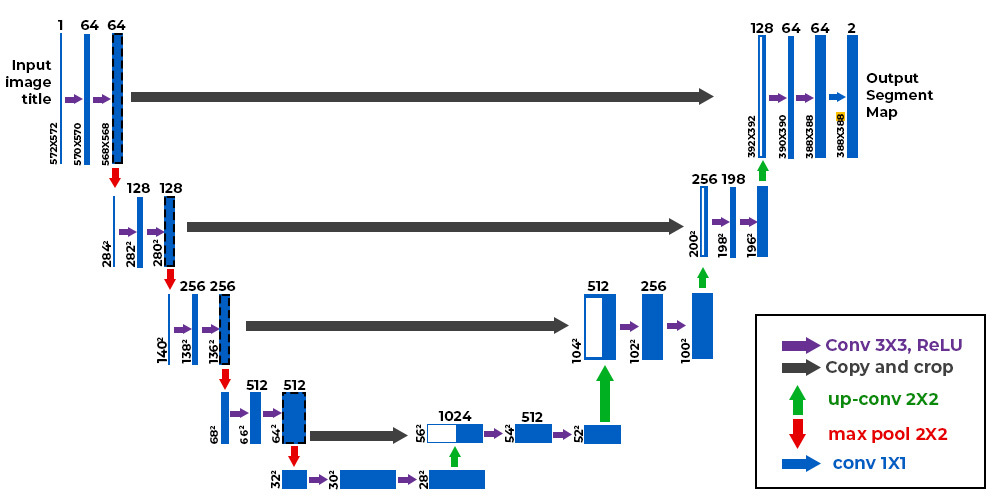

---

## **7. Mask R-CNN**

**Introduced by**: Kaiming He et al., 2017.

**Type**: Instance segmentation network.

**Key Idea**: Extends Faster R-CNN to predict a **segmentation mask** for each detected object.

**Architecture**:

1. **Backbone CNN**: Extract features (ResNet + FPN commonly used).
2. **Region Proposal Network (RPN)**: Generate proposals.
3. **RoIAlign**: Precisely extract features (avoids quantization errors).
4. **Heads**:
    - **Classification & bounding box regression** (like Faster R-CNN)
    - **Mask branch**: Pixel-level segmentation for each RoI.

**Advantages**:

- High-quality **instance segmentation**.
- Modular: can swap backbone, add feature pyramid networks (FPN).
- Works well for overlapping objects.

**Limitations**:

- Slower than single-stage detectors (YOLO, SSD).
- More complex architecture → higher training requirements.

**Use case**: Object detection + instance segmentation in autonomous vehicles, image editing, medical imaging.

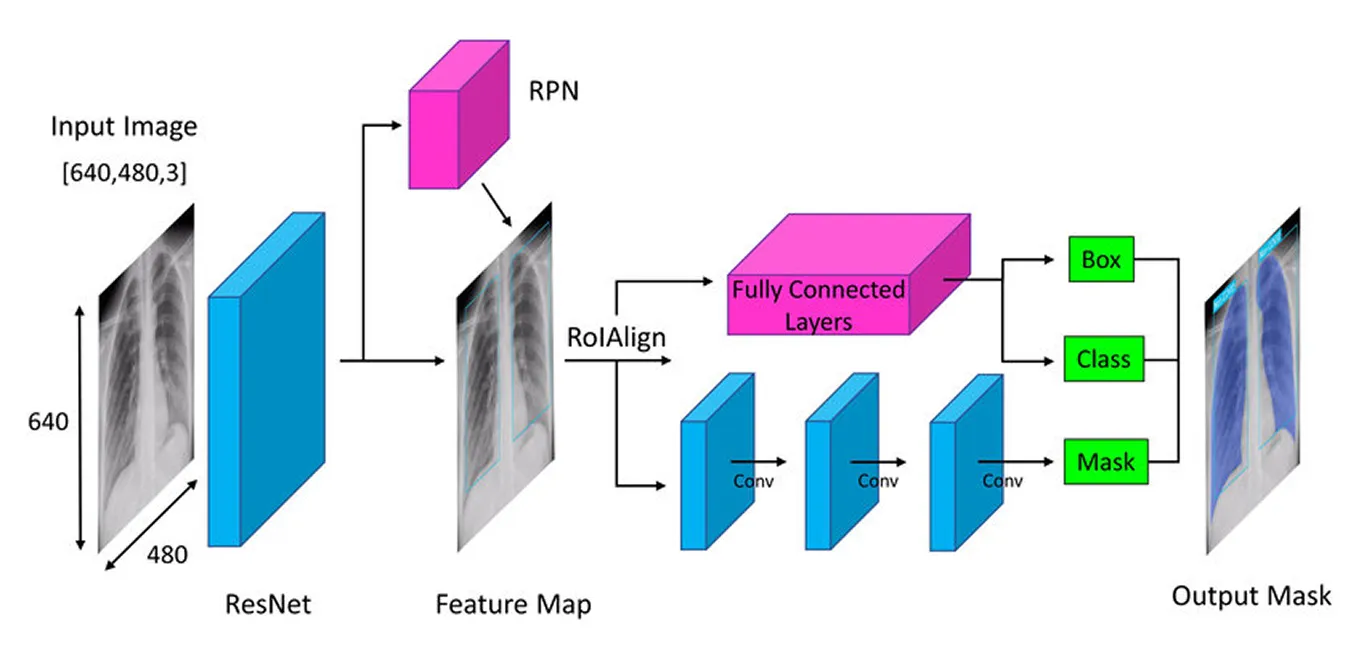

---

## **Comparison Table**

| Model | Type | Task | Speed | Accuracy | Strengths |
| --- | --- | --- | --- | --- | --- |
| R-CNN | Two-stage | Detection | Slow | Moderate | First deep-learning detector |
| Fast R-CNN | Two-stage | Detection | Moderate | High | Shared CNN, end-to-end |
| Faster R-CNN | Two-stage | Detection | Fast | Very High | RPN for proposals, end-to-end |
| YOLO | Single-stage | Detection | Very Fast | Moderate | Real-time, unified architecture |
| SSD | Single-stage | Detection | Fast | High | Multi-scale, real-time |
| U-Net | Encoder-Decoder | Semantic segmentation | Moderate | Very High | Accurate, works with small data |
| Mask R-CNN | Two-stage + mask branch | Instance segmentation | Moderate | Very High | Precise instance segmentation |

---
## **Key Takeaways**

1. **Two-stage detectors** (R-CNN family) → Higher accuracy, slower → research / high-precision tasks.
2. **Single-stage detectors** (YOLO, SSD) → Real-time detection, slightly lower accuracy → practical applications.
3. **Segmentation models** (U-Net, Mask R-CNN) → Focus on pixel-level understanding; U-Net → semantic segmentation, Mask R-CNN → instance segmentation.
4. **Choice of model** depends on:
    - Speed vs accuracy
    - Type of task (detection vs segmentation)
    - Dataset size and complexity

---

# Generative Adversarial Networks (GANs) — detailed note

## 1 — What is a GAN (intuition)

A GAN is a game between two neural networks: a **Generator** G that creates synthetic samples (images, audio, etc.) from noise zzz, and a **Discriminator** D that tries to tell real samples from generated ones. Training is adversarial: G gets better at producing realistic samples by trying to fool D; D gets better at spotting fakes. At equilibrium, generated samples are indistinguishable (in distribution) from real data. 

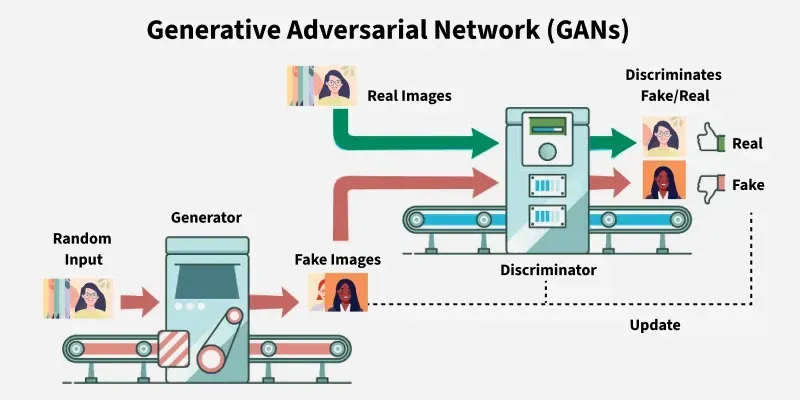

---

## 2 — Core mathematical formulation

The original GAN objective (minimax) is:

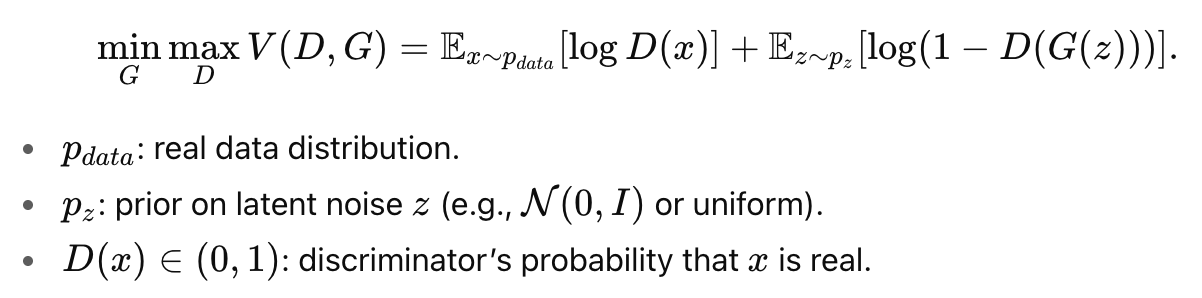

Commonly used surrogate losses (practical training) for the generator use the *non-saturating* version:

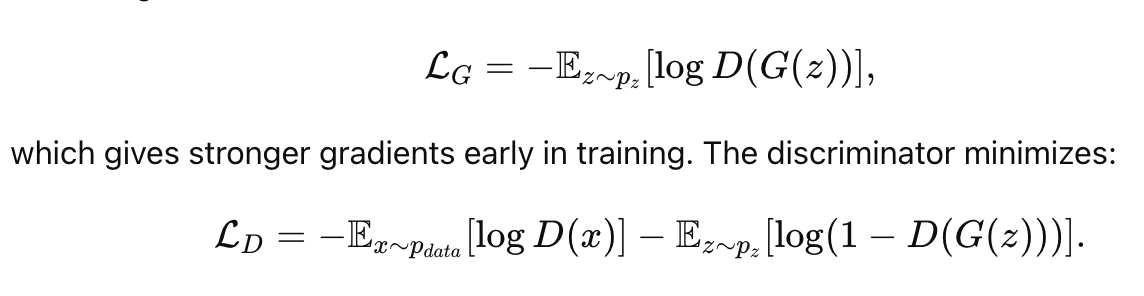

These are the foundational formulas used in most tutorials. 

---

## 3 — Architectures & practical building blocks

### a) Vanilla GAN

- Simple MLP generator and discriminator. Useful for toy problems, low-dimensional data.
  
### b) DCGAN (Deep Convolutional GAN)

- Uses convolutional (and transposed convolution) layers in D and G respectively; recommended architectural guidelines (batch norm, no pooling, strided convs, ReLU in generator except output, LeakyReLU in discriminator). This is the standard baseline for image GANs.
  
### c) Conditional GAN (cGAN)

- Condition both G and D on class labels y (concatenate or embed label). Enables targeted generation (e.g., generate images of a specified class).

### d) Advanced: Wasserstein GAN (WGAN/WGAN-GP), CycleGAN, SRGAN, StyleGAN

- WGAN replaces JS divergence objective with an approximation of Wasserstein distance for more stable gradients; WGAN-GP adds gradient penalty to enforce Lipschitz constraint.
- CycleGAN learns mappings between two domains without paired data (image-to-image translation).
- SRGAN tackles image super-resolution using perceptual losses.
- StyleGAN designs sophisticated generator control over style/structure. (These are important families you’ll encounter in practice.) 

---

## 4 — Training recipe & engineering tips (practical)

- **Alternating updates**: train D for k steps, then G for 1 step (often k=1).
- **Batch normalization**: use in both G and D in most cases (except some layers like output / input).
- **Activation functions**: ReLU in G(except output), LeakyReLU in D, final G output often tanh (if data normalized to [−1,1]) or sigmoid for [0,1]. 
- **Optimizers**: Adam (with $β1≈0.5, β2≈0.999$) is a common default; tune learning rates (e.g., 2e−4). 
- **Label smoothing / noisy labels**: apply soft labels or flip a small percentage of labels to regularize D.
- **Batch size**: smaller batch sizes can help in some cases; but balance with stability and compute constraints.
- **Normalization of data**: ensure images scaled to match G's output activation (e.g., [−1,1] with tanh).

These choices significantly affect convergence and stability. 

---

## 5 — Common failure modes & fixes

- **Mode collapse**: G maps many zzz to the same output (low diversity). Fixes: minibatch discrimination, feature matching, unrolled GAN, Wasserstein loss, or architectural changes. 
- **Vanishing gradients for G**: if DDD becomes too strong early, G gets tiny gradients. Fixes: use non-saturating loss, train G more often, or use WGAN. [
- **Oscillations / failure to converge**: due to adversarial min-max dynamic. Fixes: learning rate tuning, careful architecture, gradient penalty, spectral normalization. 

---

## 6 — Loss variants & theory highlights

- **JS divergence / KL**: original GAN objective relates to Jensen-Shannon divergence between real and generated distributions. This can lead to gradient issues when supports do not overlap. 
- **Wasserstein distance (WGAN)**: uses Earth-Mover distance which provides smoother gradients; requires 1-Lipschitz critic (via weight clipping or gradient penalty). WGAN often yields more stable training and better mode coverage. 
- **Least Squares GAN (LSGAN)**: replaces cross-entropy with least-squares loss to stabilize training and produce higher quality images in some cases.

---

## 7 — Evaluation metrics

GAN evaluation is hard — there’s no single perfect metric. Commonly used:

- **Inception Score (IS)**: measures quality and diversity via a pretrained Inception network — high IS suggests realistic and varied images.
- **Fréchet Inception Distance (FID)**: compares statistics (means, covariances) of real vs generated feature distributions — lower is better; more reliable than IS.
- **Perceptual / human evaluation**: user studies; often necessary for high-stakes visual quality judgment. 

---

## 8 — Applications (real-world uses)

- **Image synthesis & editing** (faces, scenes) — e.g., novel realistic images, style transfer.
- **Super-resolution** (SRGAN) — upscaling low-res images with plausible detail.
- **Image-to-image translation** — domain transfer, colorization, style transfer (CycleGAN, pix2pix).
- **Data augmentation** — generate synthetic training samples (careful: distribution mismatch risk).
- **Anomaly detection** — high reconstruction or discriminator error can signal anomalies.
- **Creative media** — art generation, music, text (with conditional/sequence GAN variants). 
---

## 9 — Implementation notes

1. **Start small**: use DCGAN architecture on a low-res dataset (MNIST/CIFAR-10) to get a feel. 
2. **Normalize inputs**: scale images to [−1,1] if using tanh output.
3. **Use Adam** with $β1=0.5$ initially; $LR =2e^{−4}$ is a common baseline. 
4. **Alternate training**: 1 step D, 1 step G (or adjust k for stability).
5. **Checkpoint & visualize** samples frequently — tracing sample quality over iterations helps diagnose problems early.
6. **Try WGAN-GP** if training is unstable or mode collapse is severe. [Analytics Vidhya]

---

## 10 — Quick glossary

- **Generator (G)**: network producing fake samples from noise.
- **Discriminator (D)**: network classifying real vs fake.
- **Latent vector (z)**: random noise input to GGG.
- **Mode collapse**: generator produces limited variety.
- **Adversarial loss**: objective that pits GGG vs DDD.
- **WGAN**: Wasserstein GAN variant improving training stability.

---

## Final practical checklist (if you want to implement a GAN quickly)

1. Pick dataset (start simple).
2. Build DCGAN-style GGG and DDD (ConvTranspose + Conv + BatchNorm + LeakyReLU pattern).
3. Normalize data to match GGG’s final activation.
4. Use Adam (lr=2e−4lr=2e{-4}lr=2e−4, β1=0.5\beta_1=0.5β1=0.5).
5. Train with alternating steps, monitor samples, use FID/IS for metrics.
6. If unstable, try WGAN-GP or spectral normalization; use label smoothing and small amounts of noise in labels/inputs.

---

# Interpretability, Feature Visualization, Grad-CAM & Saliency Maps — detailed note

## 1. Why interpretability matters 

- Deep CNNs are powerful but often opaque (“black boxes”). Interpretability techniques tell **which parts of the input** or **which internal features** drive a model’s decision — useful for debugging, trust, fairness, and scientific insight.

---

## 2. Feature visualization — what & how

**Goal:** reveal what individual units (filters, channels, neurons) or layers have learned — i.e., what input patterns *maximally activate* them.

### Main approaches

1. **Feature / activation maps (forward visualization)**
    - For a given input image, record the output activations of convolutional filters at a chosen layer and display them as images. This shows how the network responds spatially to real inputs (edge detectors, textures, object parts in deeper layers). Implementation typically uses forward hooks (PyTorch) or model outputs.
2. **Activation maximization (gradient ascent / feature inversion)**
   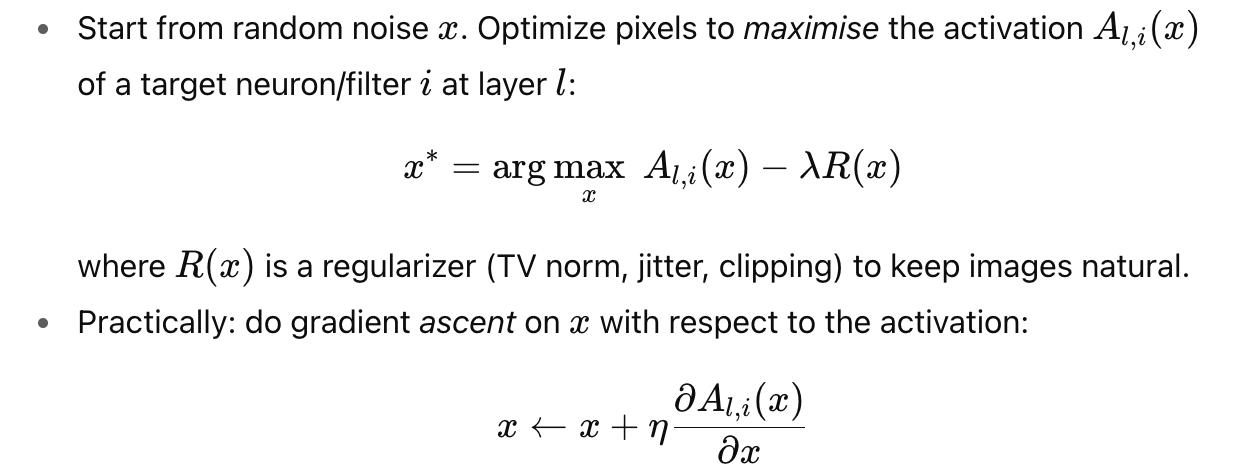
        
    - Regularizers and multi-scale/jitter steps are crucial to get interpretable visuals. 
3. **Feature inversion / optimization with constraints**
    - More advanced: constrain magnitude, use natural image priors, or use magnitude-constrained optimization (recent improvements) to yield clearer feature images. See newer optimization-based papers for improved techniques. 

### Practical tips

- Visualize many channels at once as a grid of heatmaps.
- Use different input seeds and average to reveal stable patterns.
- Combine with guided methods (see below) for higher-resolution saliency.

---

## 3. Saliency maps — basic idea & math

**Goal:** For a given input xxx and target output score S_c(x) (e.g., logit or class probability for class c), produce a per-pixel map showing how much small changes in each pixel would affect S_c.

### Vanilla saliency (gradient) map

- Compute the gradient of the target score wrt input pixels:M(x)=∂x∂Sc(x)
    
   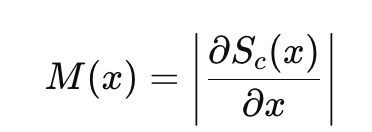
    
- Take absolute values (or positive part), and optionally aggregate over color channels (e.g., max or L2 across RGB) to get a grayscale saliency map. High values ⇒ pixels that strongly influence the score.

### Variants / improvements

- **SmoothGrad:** average saliency over noisy copies of the input; reduces visual noise.
- **Integrated Gradients:** integrate gradients along a straight-line path from baseline x_0 (e.g., black image) to x:
    
    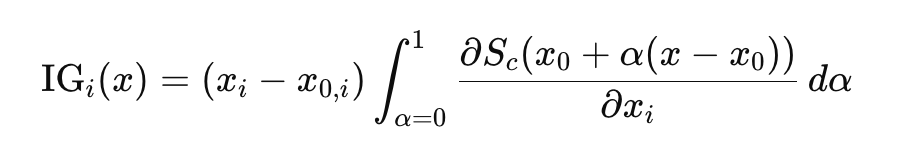
    
    — gives axiomatic attribution with baseline dependence. (Related techniques are widely used in XAI literature.)
    

**Notes:** gradients are fast to compute but can be noisy and hard to interpret in isolation; smoothing and guided backprop can help.

---

## 4. Grad-CAM (Gradient-weighted Class Activation Mapping) — the how and math

Grad-CAM produces a **coarse, class-discriminative localization map** highlighting image regions important for a class prediction. It works with any CNN and is widely used because of clarity and robustness.

### Steps & formula (original Grad-CAM)

Given:

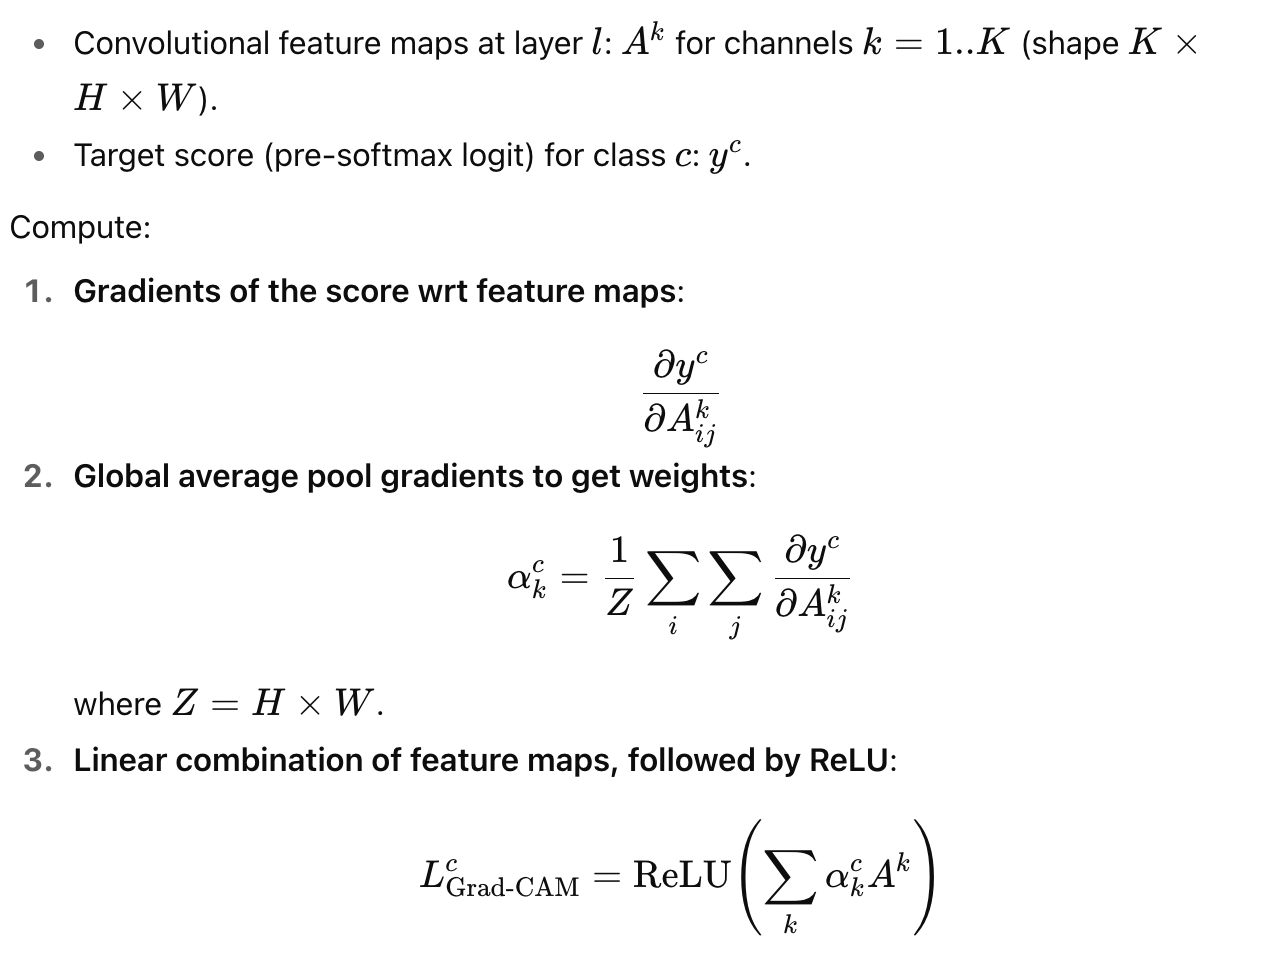
    
- ReLU focuses on features that have a positive influence on the class.

### Why it works

- Grad-CAM uses gradients to weigh feature maps by their importance to the target class. Upsampling $L^c$ to the input size produces a heatmap that localises discriminative regions (coarser than pixel-level saliency but robust and class-discriminative).

### Practical application

- Combine with guided backpropagation (“Guided-Grad-CAM”) to produce high-resolution, class-discriminative visualisations: elementwise multiply Grad-CAM heatmap (upsampled) with guided backprop saliency.

---

## 5. Implementation notes & recipes

### Which layer to pick for Grad-CAM / feature maps

- Choose the last convolutional layer (deepest conv) for Grad-CAM: it has the best tradeoff between high-level semantics and spatial resolution.
- For feature maps, examine earlier layers for edges/textures and deeper layers for object parts.

### Typical code flow (high level)

1. Preprocess input and forward pass through model.
2. For Grad-CAM: compute score $y^c$ (logit), backprop gradients to the chosen conv layer to get $∂y^c/∂A^k$.
3. Compute $α^ck$, form heatmap $L^c$, upsample to input size, optionally normalize and overlay on image. Keras and PyTorch examples abound. 

### Losses & targets

- Use **logits** rather than softmax probabilities for gradients (avoids saturation).
- For multi-label tasks, pick the logit corresponding to the label of interest.

### Code pointers & examples

- Keras official Grad-CAM example with code and visualization pipeline is a practical starting point. 
- MATLAB/MathWorks has a concise tutorial on visualization methods and demonstrated functions (useful if you use that environment).

---

## 6. Strengths & limitations

### Strengths

- **Feature maps & activation maximization** reveal learned filters and hierarchical features.
- **Saliency maps** are simple and fast (single backward pass).
- **Grad-CAM** is class-discriminative, robust, and model-agnostic for CNNs — widely adopted in practice.

### Limitations & pitfalls

- **Ambiguity**: heatmaps show correlation not necessarily causation — models can latch onto spurious cues.
- **Resolution**: Grad-CAM heatmaps are coarse (because they use conv feature maps). Guided-Grad-CAM helps but can be heuristically combined.
- **Gradient saturation/noise**: vanilla saliency gradients can be noisy and unstable; smoothing helps.
- **Baseline dependence**: Integrated gradients and some methods depend on baseline choice.
- **Adversarial sensitivity**: interpretability maps can be manipulated (research shows adversarial changes can change saliency without altering prediction). Be cautious when using explanations in critical settings.

---

## 7. Best practices & checklist

- **Normalize inputs** before visualization (same preprocessing as model training).
- **Pick the right layer** (final conv for Grad-CAM; shallower convs for low-level features).
- **Use logits** for gradient computations.
- **SmoothGrad or averaging** for noisy saliency; use regularizers for activation maximization.
- **Combine methods** (feature maps, Grad-CAM, guided backprop, Integrated Gradients) — agreement across methods increases confidence.
- **Human in loop**: always inspect multiple samples and sanity-check (randomize labels or weights to ensure explanations degrade as expected).

---

## 8. Quick math summary

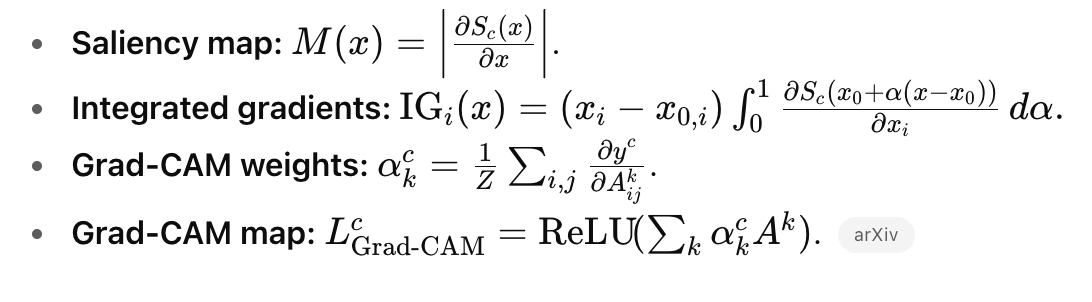

---

## 9. Where to go next (implementation links)

- Start with the **Keras Grad-CAM example** for a working notebook and visualization pipeline.
- Read the original **Grad-CAM paper** for the mathematical derivation and ablations.
- For cutting-edge feature visualization algorithms (better regularization / optimization), consult the recent papers (e.g., magnitude-constrained optimization).

---

### ✅ Summary

| Method | Focus | What it tells you |
| --- | --- | --- |
| Feature Maps | Filters | What patterns each filter detects for a given image |
| Activation Maximization | Filters | What input maximally activates a filter (abstract pattern) |
| Grad-CAM | Input regions | Which image regions are important for a class prediction |

---

# 1. Feature Map Visualization

👉 Shows what intermediate layers see for a given image.

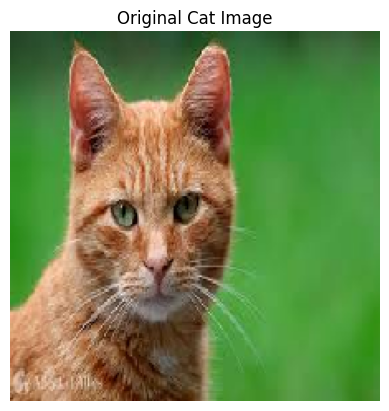

In [93]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

model = VGG16(weights='imagenet', include_top=False)

img_path = "cat.jpeg"  # Replace with your image path
img = image.load_img(img_path, target_size=(224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

plt.imshow(img)
plt.title("Original Cat Image")
plt.axis("off")
plt.show()

## Explanation
- **Imports** libraries for deep learning, image processing, and plotting.
- **Loads VGG16** without top layers for feature extraction.
- **Loads and preprocesses** the image: resizes, converts to array, adds batch dimension, normalizes pixels.
- **Displays** the original image.

✅ The processed image `x` is now ready for **feature extraction or visualization**.

In [95]:
feature_model = tf.keras.models.Model(inputs=model.input, outputs=model.output)
features = feature_model.predict(x)  # shape: (1, 7, 7, 512)
feature_vector = features.flatten()  # shape: (7*7*512,)

print("Feature vector shape:", feature_vector.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
Feature vector shape: (25088,)


- **Create feature model**: Uses VGG16 input and output to get convolutional feature maps.
- **Extract features**: Passes the image through the model → shape `(1,7,7,512)`.
- **Flatten features**: Converts 3D feature maps into 1D vector `(25088,)`.
- **Print shape**: Confirms the size of the feature vector.

✅ Result: a **flat feature vector** representing the image for downstream tasks.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


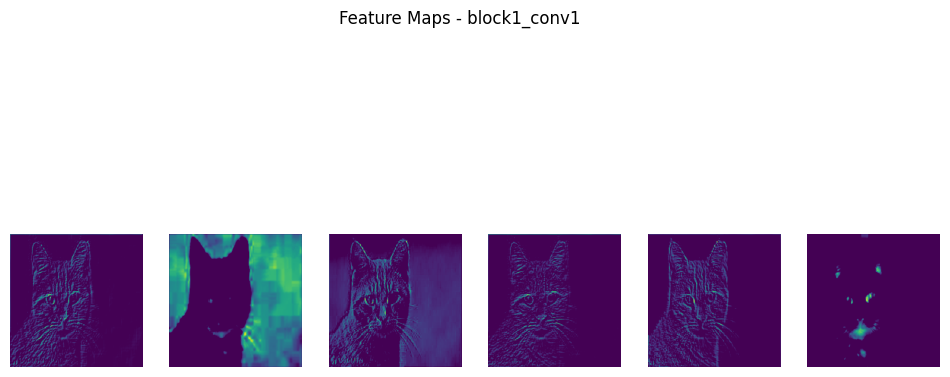

In [97]:
first_layer_model = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer('block1_conv1').output)
activations = first_layer_model.predict(x)  # shape: (1, 224, 224, 64)

n_features = 6
plt.figure(figsize=(12,6))
for i in range(n_features):
    ax = plt.subplot(1, n_features, i+1)
    plt.imshow(activations[0,:,:,i], cmap='viridis')
    plt.axis('off')
plt.suptitle("Feature Maps - block1_conv1")
plt.show()

- **Create model for first layer**: Outputs activations of `block1_conv1` to see low-level features.
- **Compute activations**: Forward pass → shape `(1,224,224,64)` (64 feature maps).
- **Visualize**: Plots the first 6 feature maps to show patterns like edges and textures.

✅ Shows what the network detects in the first convolutional layer.

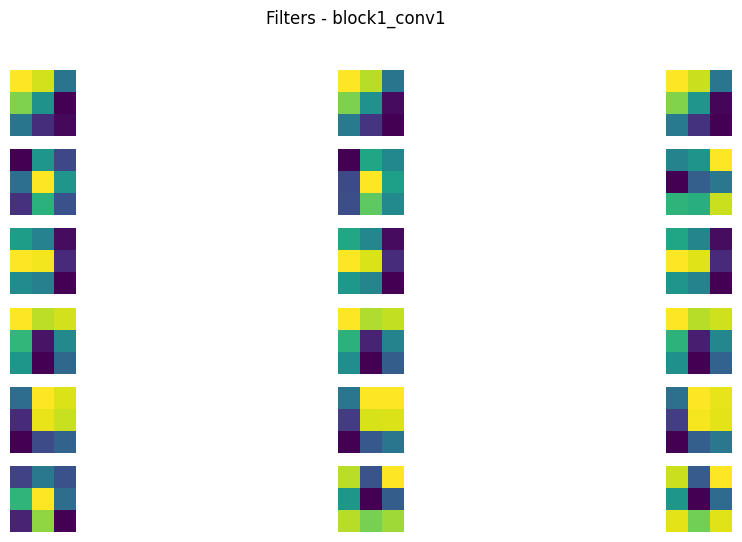

In [99]:
filters, biases = model.get_layer('block1_conv1').get_weights()
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)


plt.figure(figsize=(12,6))
for i in range(n_features):
    f = filters[:,:,:,i]
    for j in range(3):  # RGB channels
        ax = plt.subplot(n_features, 3, i*3+j+1)
        plt.imshow(f[:,:,j], cmap='viridis')
        plt.axis('off')
plt.suptitle("Filters - block1_conv1")
plt.show()

- **Get filters and biases**: Extracts learned weights from `block1_conv1`.
- **Normalize**: Scales filter values to `[0,1]` for display.
- **Visualize**: Plots first 6 filters across RGB channels to show **patterns the network learned**.

✅ Shows what the first convolutional layer detects (edges, colors, textures).

---

# 2. Grad-CAM, Saliency Maps

👉 Highlights **which regions in an input image influenced a class decision**.

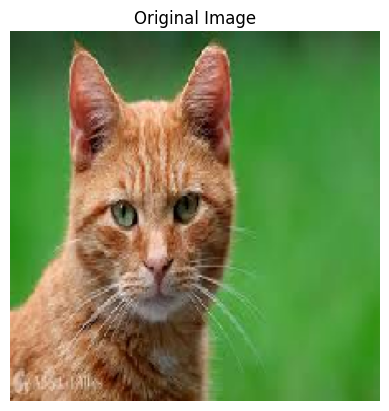

In [102]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

model = VGG16(weights='imagenet')  # full VGG16

img_path = 'cat.jpeg'  # replace with your image
img = image.load_img(img_path, target_size=(224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

plt.imshow(img)
plt.title("Original Image")
plt.axis("off")
plt.show()

- **Load VGG16** with full pretrained weights.
- **Load and preprocess image**: resize to 224×224, convert to array, add batch dimension, normalize.
- **Display image**: shows the original input before feeding it into the network.

In [104]:
preds = model.predict(x)
class_idx = np.argmax(preds[0])
print("Predicted class index:", class_idx)

last_conv_layer = model.get_layer('block5_conv3')
grad_model = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(x)
    loss = predictions[:, class_idx]

grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
heatmap = heatmap[0].numpy()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
Predicted class index: 282


/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_101']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


- **Predict class**: Get the predicted class index for the input image.
- **Grad-CAM model**: Outputs last conv layer activations and predictions.
- **Compute gradients**: Gradient of the class score w.r.t. conv layer.
- **Generate heatmap**: Weight and sum channels → normalize → highlights regions important for the prediction.

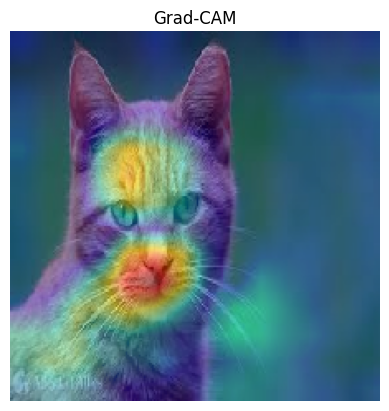

In [106]:
import cv2
heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR), 0.6, heatmap, 0.4, 0)

plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title("Grad-CAM")
plt.axis("off")
plt.show()

- **Resize heatmap** to match image size and scale to 0–255.
- **Apply color map** (`JET`) for visualization.
- **Superimpose** heatmap on original image using weighted sum.
- **Display** the resulting Grad-CAM image showing important regions for the prediction.

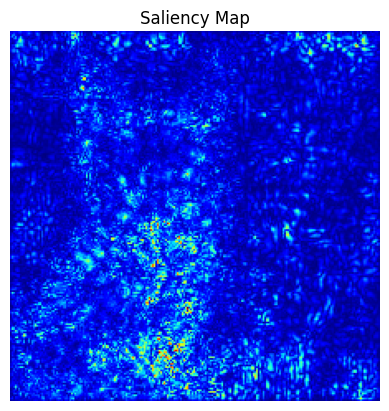

In [108]:
x = tf.convert_to_tensor(x)
with tf.GradientTape() as tape:
    tape.watch(x)
    preds = model(x)
    loss = preds[:, class_idx]

saliency = tape.gradient(loss, x)
saliency = tf.reduce_max(tf.abs(saliency), axis=-1)[0]
saliency = (saliency - tf.reduce_min(saliency)) / (tf.reduce_max(saliency) - tf.reduce_min(saliency))

plt.imshow(saliency, cmap='jet')
plt.title("Saliency Map")
plt.axis("off")
plt.show()

- **Convert input to tensor** and watch it for gradients.
- **Compute gradient** of class score w.r.t. input image.
- **Create saliency map**: take max absolute gradient across channels, normalize to 0–1.
- **Display** using `jet` colormap → highlights pixels most influencing the prediction.